In [2]:
import datetime
import seaborn as sns
import pandas as pd
import numpy as np
import pysal
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster
import geopandas as gpd
from matplotlib import pyplot as plt
from shapely.geometry import shape
from shapely.geometry import Point
import requests
import random
import overpy
import contextily as ctx
import mplleaflet

In [3]:
import warnings
warnings.simplefilter("ignore")

In [3]:
import gc
gc.collect()

51

In [4]:
%matplotlib inline  

## Research questions and project objectives


Tourism is recognised an important part of city's growth: it makes money for city, bousts the upgrading of its infrastructure and promotes it around the world. That is why, providing of essential tourist facilities is a one of major objectives of tourism related policies of an every city who seeks to attract tourists. Such facilities as hotels, cafes, information centers, sings, maps, souvenir shops and other influence the quality of visit a lot. They brings tourist satisfaction, increases travel demand, and also inject more income into the urban tourism industry (Ebrahimzadeh1, Marzie Daraei, 2014)

Regarding the Moscow tourist strategy (2015) Moscow is  a city who have an ambition to increase annual tourist flow till 20 millions. In order to do this the government should be concious about the quality of tourist infrastructure.

Among all tourist needs, the need for information is the most important because it will help him to find his hotel, discover attractions nearby or find a place to feed up. While it is very difficult to find yourself in a new city  without a help, in a such big one as Moscow it is almost impossible.  For the purpose of providing tourists with information, in 2013 the government issued an order (https://base.garant.ru/70551996/) to install essential tourist infrastructure in Moscow, including tourist centres and maps. They are assumed to serve people who is new in the city and can't or don't want to get information online.

However the only presence of information on the streets doesn't garantee that tourists will obtain it. The right allocation of them is important to reach as many visitors as possible.  That is why, the goals of this project is to define touristic places,  assess what part of this area is covered by current maps and tourist information offices, and propose improvement of their allocation. 

In this work facility approach to analyzing urban tourism proposed by Ashworth (1989) was applied. While the one of data sources of this project is a tourist density dataset, the most attractive places for tourist were finally defined based  on facilities and attractions located there. It happened because the only one week of statistic was available which cant be used as true numbers for whole year but which is enough to recognise relationships between surrounding infrastructure and tourist numbers.
Moreover, we expect Moscow to develop further, so new spots will appear there and it is important to predict their popularity and set necessary information points until they get touristic.


In order to achieve this purpose next steps were carried out:
 1. GeoData about tourist density, facilities and attractions were extracted from three sources, cleaned and transformed
 2. Datasets were matched and visualised to present tourist denstiy and the distribution of attraction and tourist accomodations across of Moscow
 3. _XGBoost_ regression model was trained to identify relations beetween presence of tourist amenities and popularity of places 
 4. _Decision tree_ classification model was built to determine simple criteria for future decisions about a place of new map or information offices
 5. KMeans clustering models were built to find the best locations for information offices and maps in order to maximise the number of covered tourists

The limitations of current work is a small time period of observations of tourist density,using Euclidean distance between objects instead of real route time,  and the limited list of facilities and attractions. In this paper we suggested that following places and sights can determine tourist's density at different places around Moscow: 
    - Attractions ( Museum, cultural heritage, theatres)
    - sport venues
    - Parks and pedestrian areas
    - Railway stations
    - Accomodations

## Data collection 

For this project data from three sources was obtained. Each of them were stored in different format,thus requiring to apply  different techniques to collect and process this data
<ul> 
    <li> Data of tourist density. Source: CSV file + ESRI Shapefile  given on Moscow Tourist Hachathon</li>
    <li> Data of tourist facilities: information centres +railway stations+hotels. Source: API OpenStreetMap </li>
    <li> Data of tourist attractions. Source: Moscow Open Data Portal </li>
</ul> 

Next, it is explained how data was collected and what transformation were made to prepare data first for matching with each other and then for analysing

### Extracting tourist density

The first source of data is a dataset of number of people for every half an hour in each 500x500 metres square of Moscow. The dataset contains 14956799 observations dated from 1st till 7th April 2018.  This dataset was provided by the Department of Technologies of Moscow during Moscow Travel Hackathon held on 08 February this year and was openly published on the event's website https://travelhack.moscow/task/russpass ( to go to the folder with files use this link https://www.dropbox.com/sh/9n3st82eea5g3qz/AABSiVyLc4CfHpGOCRoWtBATa?dl=0)
 
As we can see below the dataset contains six features which have the following interpretation
    <ul>
    <li>'ts' is a start time of every 30 minutes interval</li>
    <li>'zid' is a ID of observing square </li>
    <li>'sum' is a total number of people passing this square</li>
    <li>'sum.1' is a total number of people working in this square not less then 60 minutes</li>
    <li>'sum.2' is a total number of people working in this square( they regularly stay there from 10am till 5pm during weekdays) </li>
    <li>'sum.3' is a total number of people living in this square ( they regularly stay there from 11 pm till 6am during weekdays) </li>
    <li>'tourist' is a total number of tourists passing this square </li>
    </ul>
 

In [6]:
df_new=pd.read_csv(r'C:\Users\Intra24\Documents\hack_tourist\full_density.csv')

In [7]:
df_new.head()

Unnamed: 0                   ts  zid  tourist  sum  sum.1  sum.2  sum.3
0           0  2018-04-01 00:00:00   10        3    3      0      3      0
1           1  2018-04-01 00:00:00   19        2    4      2      4      0
2           2  2018-04-01 00:00:00   20        2    3      3      3      0
3           3  2018-04-01 00:00:00   21        2    2      2      2      0
4           4  2018-04-01 00:00:00   24        3   10     10     10      0

Among features there is no anyone related to location. For this purpose we used 'fishnet' file also provided for Hachathon. This file also contains ID of square as well as its location. It was provided  in 'epsg 4326' cordinate reference system in Esri Shapefile format

In [61]:
fish=gpd.read_file(r"C:\Users\Intra24\Documents\hack_tourist\fishnet\fishnet.shp")
print(fish.crs)
fish.head()

{'init': 'epsg:4326'}


Id                                           geometry
0   0  POLYGON ((38.64721 54.25524, 38.64733 54.25973...
1   1  POLYGON ((38.65488 54.25517, 38.65500 54.25966...
2   2  POLYGON ((38.66255 54.25510, 38.66268 54.25959...
3   3  POLYGON ((38.67022 54.25502, 38.67035 54.25951...
4   4  POLYGON ((38.67789 54.25495, 38.67802 54.25944...

First of all, the quality of dataset should be checked before performing further analysis. For this data missings and negative values were checked. Verifying negative values is important because it is evident that number of people can be less than zero.After running verification we can see that this dataset does not have neither missings nor negative features 

In [9]:
df_new.isnull().sum()

Unnamed: 0    0
ts            0
zid           0
tourist       0
sum           0
sum.1         0
sum.2         0
sum.3         0
dtype: int64

In [10]:
(df_new[df_new.columns[2:]]<0).sum()

zid        0
tourist    0
sum        0
sum.1      0
sum.2      0
sum.3      0
dtype: int64

In order to work with data we should transform 'ts' column into datatime one as intially it has a string format. Also for analysing later a daily activity we have created separate features for 'time' and 'date'. Next, columns not related to tourist numbers were dropped.  Last, we match this dataset with fishnet by square's Id, thus creating GeoDataFrame dataset of shape 14956799x7

In [11]:
print (' Type of "ts" column is ' , df_new['ts'].dtype)

 Type of "ts" column is  object


In [12]:
df_new['date_full']=pd.to_datetime(df_new['ts'])
df_new['date']=df_new.ts.apply(lambda x: x.split(' ')[0])
df_new['time']=df_new.ts.apply(lambda x: x.split(' ')[1])

In [13]:
df_new.drop('ts', inplace=True, axis=1)

In [14]:
df_new.drop(df_new.columns[0], axis=1, inplace=True)
df_new.rename(columns={'zid':'Id'}, inplace=True)

In [15]:
df_new.drop(['sum','sum.1','sum.2', 'sum.3'], axis=1, inplace=True)

In [16]:
df_new=gpd.GeoDataFrame(df_new.merge(fish[['Id','geometry']], on='Id'), crs={'init': 'epsg:4326'})

### Obtaining data of tourist facilities

In order to obtain data about tourists facilities OpenStreetMap database was queried using Overpass API. In particular, data related to Moscow area (called _"Москва"_ in code) by tags _'tourism'_  and _'railway'='station'_  was extracted. However only several keys are interesting for us within this project that represent accomodation category,  railway stations and information centres. 


In [18]:
def get_osm(api, city, tag, key=None): # query OpenStreetMap data
    if key is None:
        query="""area["name"=%s];node[%s](area);out;"""%('"'+city+'"','"'+tag+'"')
    else:
        query="""area["name"=%s];node[%s=%s](area);out;"""%('"'+city+'"','"'+tag+'"','"'+key+'"')
    print(query)
    result = api.query(query)
    amenities=set([i.tags[tag] for i in result.nodes])
    return amenities, result

api = overpy.Overpass()
moscow_tour, results1=get_osm(api, 'Москва', 'tourism')
moscow_railways, results=get_osm(api, 'Москва', 'railway', 'station')

area["name"="Москва"];node["tourism"](area);out;
area["name"="Москва"];node["railway"="station"](area);out;


In [48]:
tourist_cat=[ 
 'apartment',
 'guest_house',
 'hostel',
 'hotel',
 'information',
 'motel'
]

From the extracted results we selected only interesting to us categories and stored them in GeoDataFrame format. As we are going to overay this data with tourist density dataset we need only the name of category and the coordinates of a place. Totally we got dataset with 16082 observations



In [227]:
df_tourist=gpd.GeoDataFrame([ Point(x.lon, x.lat) for x in results1.nodes if x.tags['tourism'] in tourist_cat] , columns=['geometry'])
df_tourist['facility']=[x.tags['tourism']  for x in results1.nodes if x.tags['tourism'] in tourist_cat]
df_tourist['tags']=[x.tags  for x in results1.nodes if x.tags['tourism'] in tourist_cat]
df_railways=gpd.GeoDataFrame([ Point(x.lon, x.lat) for x in results.nodes] , columns=['geometry'])
df_railways['facility']='railway_station'
df_railways['tags']=[x.tags for x in results.nodes]

df_osm=pd.concat([df_railways, df_tourist])

df_osm=gpd.GeoDataFrame(df_osm, crs={'init':'epsg:4326'})

In [13]:
df_osm.to_file('df_osm_last.json' , driver='GeoJSON')

# df_osm=gpd.read_file(r'C:\Users\Intra24\Glasgow\Group_project\df_osm_last.json')


In [11]:
df_osm=gpd.read_file(r'C:\Users\Intra24\Desktop\Glasgow_uni\Group_project\df_osm_last.json')

In [12]:
df_osm.head()

facility                                               tags  \
0  railway_station  {'alt_name': 'Москва-Октябрьская', 'esr:user':...   
1  railway_station  {'alt_name': 'Кунцево', 'esr:user': '181704', ...   
2  railway_station  {'colour': 'orange', 'layer': '-1', 'name': 'М...   
3  railway_station  {'colour': 'orange', 'layer': '-2', 'name': 'Б...   
4  railway_station  {'express:user': '2000001', 'loc_name': 'Курск...   

                    geometry  
0  POINT (37.65372 55.77883)  
1  POINT (37.44989 55.72687)  
2  POINT (37.66155 55.88718)  
3  POINT (37.66418 55.86963)  
4  POINT (37.66218 55.75777)

### Obtaining Moscow attractions data

In order to extract data of Moscow attractions we queried OpenData portal of Moscow - https://data.mos.ru/( english version availble)  To work with data from this portal, first API key was requested which allows to access any collection available on the portal. Technically, accessing data from Jupyter Notebook was carried out by using  the _request_ library. It allows to make HTTP requests to web-source and download data in json format. Ultimetely, data collection process took two steps that were coded as three functions:
<ul>
    <li> get_dict_objects - requests all collections which contains geodata and which belong to categories ' Culture' and 'Sport' ( numbers 5 and 162) and stores them in JSON format </li>
    <li> 
        get_df_attract - transforms JSON first into pandas DataFrame and them into GeoDataFrame by converting coordintaes into geometry 
    </li>
</ul>
 Due to these steps data from 61 collections were obtained

In [57]:
def get_dict_objects(list_cat, api_key):
    url='https://apidata.mos.ru/v1/datasets/?api_key=%s'%(api_key)
    r = requests.get(url)
    if r.status_code==200:
        datasets=r.json()
#         print(datasets[0].keys())
        datasets[0]['ContainsGeodata']==True
        super_big_dict=dict()
        for i in range(len(datasets)):
            idi=datasets[i]['Id'] 
            if datasets[i]['ContainsGeodata'] and datasets[i]['CategoryId'] in list_cat and datasets[i]['IsArchive']==False :
                print(idi)
                url='https://apidata.mos.ru/v1/features/%d/?api_key=%s'%(idi, api_key)
                r = requests.get(url)
                super_big_dict[idi]=r.json()
                #print(idi, super_big_dict[idi].keys())
                super_big_dict[idi]['Caption']=datasets[i]['Caption']
                super_big_dict[idi]['CategoryId']=datasets[i]['CategoryId']
                super_big_dict[idi]['DepartmentId']=datasets[i]['DepartmentId']
    else: print (r)    
    return super_big_dict

def get_df_attract(big_dict):
    df=pd.DataFrame()
    i=0
    for k,v in big_dict.items():
        df=pd.DataFrame(v['features'])
        df['Caption']=v['Caption']
        df['CategoryId']=v['CategoryId']
        df['DepartmentId']=v['DepartmentId']
        if i==0:
            df_fin=df.copy()
        else:
            df_fin=pd.concat([df_fin, df], axis=0)
        i+=1  
    df_fin['geometry']=df_fin['geometry'].apply(lambda x: shape(x))
    df_fin['dataset_id']=df_fin['properties'].apply(lambda x: x['DatasetId'])
    df_fin=df_fin.reset_index()
    return gpd.GeoDataFrame(df_fin, crs={'init': 'epsg:4326'}, geometry='geometry')


In [58]:
# our consts
api_key='a2327bd3ff5aceb690bbb7b3199bfddf'
list_cat=[5,162]

In [59]:
dict_attract=get_dict_objects(list_cat,api_key) # get in json format
df_attract=get_df_attract(dict_attract) # transform to dataframe

493
495
498
526
527
528
529
530
531
613
614
885
886
888
889
890
893
894
895
898
902
905
912
917
920
1034
1181
1232
1251
1255
1384
1385
1386
1387
1388
1389
1465
2115
2116
2249
2251
2252
2264
2269
2456
2465
2541
2801
3101
3222
3227
3286
3387
3388
60622
60623
60624
60869
61161
61221
61223


In [60]:
df_attract['dataset_id'].nunique()

61

In [366]:
df_attract.head()

index                                           geometry  \
0      0                     MULTIPOINT (37.82087 55.75880)   
1      1  MULTIPOINT (37.17137 55.98769, 37.18698 55.976...   
2      2  MULTIPOINT (37.71334 55.87074, 37.67920 55.86456)   
3      3                     MULTIPOINT (37.73302 55.70789)   
4      4                     MULTIPOINT (37.59502 55.59728)   

                                          properties     type  \
0  {'DatasetId': 493, 'VersionNumber': 3, 'Releas...  Feature   
1  {'DatasetId': 493, 'VersionNumber': 3, 'Releas...  Feature   
2  {'DatasetId': 493, 'VersionNumber': 3, 'Releas...  Feature   
3  {'DatasetId': 493, 'VersionNumber': 3, 'Releas...  Feature   
4  {'DatasetId': 493, 'VersionNumber': 3, 'Releas...  Feature   

                 Caption  CategoryId  DepartmentId  dataset_id  
0  Дома культуры и клубы           5             8         493  
1  Дома культуры и клубы           5             8         493  
2  Дома культуры и клубы           5             8         493  
3  Дома культуры и клубы           5             8         493  
4  Дома культуры и клубы           5             8         493

In [64]:
df_attract.shape

(17018, 8)

In [65]:
df_attract.to_file('open_moscow.json', driver='GeoJSON' )

In [46]:
df_attract=gpd.read_file(r'C:\Users\Intra24\Desktop\Glasgow_uni\Group_project\open_moscow.json')

In [43]:
df_attract.shape

(17018, 8)

## Data processing

### Common step for all datasets: remove data outside Moscow circle road

First of all, from all datasets we remove observations which relate to places located outside Moscow boarders. For this purpose we used a Polygon describing Moscow Circle Road (MKAD) which is the boarder of the city.The coordinates were extracted from this example - https://tech.yandex.ru/maps/jsbox/2.1/route_inside_polygon. Before applying them to our dataframes, the order  of latitude and longtitude in Polygon coordinates has been changed to suit GeoDataFrame standards.

In [65]:
mkad_original=([55.78000432402266,37.84172564285271],[55.775874525970494,37.8381207618713],[55.775626746008065,37.83979446823122],[55.77446586811748,37.84243326983639],[55.771974101091104,37.84262672750849],[55.77114545193181,37.84153238623039],[55.76722010265554,37.841124690460184],[55.76654891107098,37.84239076983644],[55.76258709833121,37.842283558197025],[55.758073999993734,37.8421759312134],[55.75381499999371,37.84198330422974],[55.749277102484484,37.8416827275085],[55.74794544108413,37.84157576190186],[55.74525257875241,37.83897929098507],[55.74404373042019,37.83739676451868],[55.74298009816793,37.838732481460525],[55.743060321833575,37.841183997352545],[55.73938799999373,37.84097476190185],[55.73570799999372,37.84048155819702],[55.73228210777237,37.840095812164286],[55.73080491981639,37.83983814285274],[55.729799917464675,37.83846476321406],[55.72919751082619,37.83835745269769],[55.72859509486539,37.838636380279524],[55.727705075632784,37.8395161005249],[55.722727886185154,37.83897964285276],[55.72034817326636,37.83862557539366],[55.71944437307499,37.83559735744853],[55.71831419154461,37.835370708803126],[55.71765218986692,37.83738169402022],[55.71691750159089,37.83823396494291],[55.71547311301385,37.838056931213345],[55.71221445615604,37.836812846557606],[55.709331054395555,37.83522525396725],[55.70953687463627,37.83269301586908],[55.70903403789297,37.829667367706236],[55.70552351822608,37.83311126588435],[55.70041317726053,37.83058993121339],[55.69883771404813,37.82983872750851],[55.69718947487017,37.82934501586913],[55.69504441658371,37.828926414016685],[55.69287499999378,37.82876530422971],[55.690759754047335,37.82894754100031],[55.68951421135665,37.827697554878185],[55.68965045405069,37.82447346292115],[55.68322046195302,37.83136543914793],[55.67814012759211,37.833554015869154],[55.67295011628339,37.83544184655761],[55.6672498719639,37.837480388885474],[55.66316274139358,37.838960677246064],[55.66046999999383,37.83926093121332],[55.65869897264431,37.839025050262435],[55.65794084879904,37.83670784390257],[55.65694309303843,37.835656529083245],[55.65689306460552,37.83704060449217],[55.65550363526252,37.83696819873806],[55.65487847246661,37.83760389616388],[55.65356745541324,37.83687972750851],[55.65155951234079,37.83515216004943],[55.64979413590619,37.83312418518067],[55.64640836412121,37.82801726983639],[55.64164525405531,37.820614174591],[55.6421883258084,37.818908190475426],[55.64112490388471,37.81717543386075],[55.63916106913107,37.81690987037274],[55.637925371757085,37.815099354492155],[55.633798276884455,37.808769150787356],[55.62873670012244,37.80100123544311],[55.62554336109055,37.79598013491824],[55.62033499605651,37.78634567724606],[55.618768681480326,37.78334147619623],[55.619855533402706,37.77746201055901],[55.61909966711279,37.77527329626457],[55.618770300976294,37.77801986242668],[55.617257701952106,37.778212973541216],[55.61574504433011,37.77784818518065],[55.61148576294007,37.77016867724609],[55.60599579539028,37.760191219573976],[55.60227892751446,37.75338926983641],[55.59920577639331,37.746329965606634],[55.59631430313617,37.73939925396728],[55.5935318803559,37.73273665739439],[55.59350760316188,37.7299954450912],[55.59469840523759,37.7268679946899],[55.59229549697373,37.72626726983634],[55.59081598950582,37.7262673598022],[55.5877595845419,37.71897193121335],[55.58393177431724,37.70871550793456],[55.580917323756644,37.700497489410374],[55.57778089778455,37.69204305026244],[55.57815154690915,37.68544477378839],[55.57472945079756,37.68391050793454],[55.57328235936491,37.678803592590306],[55.57255251445782,37.6743402539673],[55.57216388774464,37.66813862698363],[55.57505691895805,37.617927457672096],[55.5757737568051,37.60443099999999],[55.57749105910326,37.599683515869145],[55.57796291823627,37.59754177842709],[55.57906686095235,37.59625834786988],[55.57746616444403,37.59501783265684],[55.57671634534502,37.593090671936025],[55.577944600233785,37.587018007904],[55.57982895000019,37.578692203704804],[55.58116294118248,37.57327546607398],[55.581550362779,37.57385012109279],[55.5820107079112,37.57399562266922],[55.58226289171689,37.5735356072979],[55.582393529795155,37.57290393054962],[55.581919415056234,37.57037722355653],[55.584471614867844,37.5592298306885],[55.58867650795186,37.54189249206543],[55.59158133551745,37.5297256269836],[55.59443656218868,37.517837865081766],[55.59635625174229,37.51200186508174],[55.59907823904434,37.506808949737554],[55.6062944994944,37.49820432275389],[55.60967103463367,37.494406071441674],[55.61066689753365,37.494760001358024],[55.61220931698269,37.49397137107085],[55.613417718449064,37.49016528606031],[55.61530616333343,37.48773249206542],[55.622640129112334,37.47921386508177],[55.62993723476164,37.470652153442394],[55.6368075123157,37.46273446298218],[55.64068225239439,37.46350692265317],[55.640794546982576,37.46050283203121],[55.64118904154646,37.457627470916734],[55.64690488145138,37.450718034393326],[55.65397824729769,37.44239252645875],[55.66053543155961,37.434587576721185],[55.661693766520735,37.43582144975277],[55.662755031737014,37.43576786245721],[55.664610641628116,37.430982915344174],[55.66778515273695,37.428547447097685],[55.668633314343566,37.42945134592044],[55.66948145750025,37.42859571562949],[55.670813882451405,37.4262836402282],[55.6811141674414,37.418709037048295],[55.68235377885389,37.41922139651101],[55.68359335082235,37.419218771842885],[55.684375235224735,37.417196501327446],[55.68540557585352,37.41607020370478],[55.68686637150793,37.415640857147146],[55.68903015131686,37.414632153442334],[55.690896881757396,37.413344899475064],[55.69264232162232,37.41171432275391],[55.69455101638112,37.40948282275393],[55.69638690385348,37.40703674603271],[55.70451821283731,37.39607169577025],[55.70942491932811,37.38952706878662],[55.71149057784176,37.387778313491815],[55.71419814298992,37.39049275399779],[55.7155489617061,37.385557272491454],[55.71849856042102,37.38388335714726],[55.7292763261685,37.378368238098155],[55.730845879211614,37.37763597123337],[55.73167906388319,37.37890062088197],[55.734703664681774,37.37750451918789],[55.734851959522246,37.375610832015965],[55.74105626086403,37.3723813571472],[55.746115620904355,37.37014935714723],[55.750883999993725,37.36944173016362],[55.76335905525834,37.36975304365541],[55.76432079697595,37.37244070571134],[55.76636979670426,37.3724259757175],[55.76735417953104,37.369922155757884],[55.76823419316575,37.369892695770275],[55.782312184391266,37.370214730163575],[55.78436801120489,37.370493611114505],[55.78596427165359,37.37120164550783],[55.7874378183096,37.37284851456452],[55.7886695054807,37.37608325135799],[55.78947647305964,37.3764587460632],[55.79146512926804,37.37530000265506],[55.79899647809345,37.38235915344241],[55.80113596939471,37.384344043655396],[55.80322699999366,37.38594269577028],[55.804919036911976,37.38711208598329],[55.806610999993666,37.3880239841309],[55.81001864976979,37.38928977249147],[55.81348641242801,37.39038389947512],[55.81983538336746,37.39235781481933],[55.82417822811877,37.393709457672124],[55.82792275755836,37.394685720901464],[55.830447148154136,37.39557615344238],[55.83167107969975,37.39844478226658],[55.83151823557964,37.40019761214057],[55.83264967594742,37.400398790382326],[55.83322180909622,37.39659544313046],[55.83402792148566,37.39667059524539],[55.83638877400216,37.39682089947515],[55.83861656112751,37.39643489154053],[55.84072348043264,37.3955338994751],[55.84502158126453,37.392680272491454],[55.84659117913199,37.39241188227847],[55.84816071336481,37.392529730163616],[55.85288092980303,37.39486835714723],[55.859893456073635,37.39873052645878],[55.86441833633205,37.40272161111449],[55.867579567544375,37.40697072750854],[55.868369880337,37.410007082016016],[55.86920843741314,37.4120992989502],[55.87055369615854,37.412668021163924],[55.87170587948249,37.41482461111453],[55.873183961039565,37.41862266137694],[55.874879126654704,37.42413732540892],[55.875614937236705,37.4312182698669],[55.8762723478417,37.43111093783558],[55.87706546369396,37.43332105622856],[55.87790681284802,37.43385747619623],[55.88027084462084,37.441303050262405],[55.87942070143253,37.44747234260555],[55.88072960917233,37.44716141796871],[55.88121221323979,37.44769797085568],[55.882080694420715,37.45204320500181],[55.882346110794586,37.45673176190186],[55.88252729504517,37.463383999999984],[55.88294937719063,37.46682797486874],[55.88361266759345,37.470014457672086],[55.88546991372396,37.47751410450743],[55.88534929207307,37.47860317658232],[55.882563306475106,37.48165826025772],[55.8815803226785,37.48316434442331],[55.882427612793315,37.483831555817645],[55.88372791409729,37.483182967125686],[55.88495581062434,37.483092277908824],[55.8875561994203,37.4855716508179],[55.887827444039566,37.486440636245746],[55.88897899871799,37.49014203439328],[55.890208937135604,37.493210285705544],[55.891342397444696,37.497512451065035],[55.89174030252967,37.49780744510645],[55.89239745507079,37.49940333499519],[55.89339220941865,37.50018383334346],[55.903869074155224,37.52421672750851],[55.90564076517974,37.52977457672118],[55.90661661218259,37.53503220370484],[55.90714113744566,37.54042858064267],
                                                                    [55.905645048442985,37.54320461007303],[55.906608607018505,37.545686966066306],[55.90788552162358,37.54743976120755],[55.90901557907218,37.55796999999999],[55.91059395704873,37.572711542327866],[55.91073854155573,37.57942799999998],[55.91009969268444,37.58502865872187],[55.90794809960554,37.58739968913264],[55.908713267595054,37.59131567193598],[55.902866854295375,37.612687423278814],[55.90041967242986,37.62348079629517],[55.898141151686396,37.635797880950896],[55.89639275532968,37.649487626983664],[55.89572360207488,37.65619302513125],[55.895295577183965,37.66294133862307],[55.89505457604897,37.66874564418033],[55.89254677027454,37.67375601586915],[55.8947775867987,37.67744661901856],[55.89450045676125,37.688347],[55.89422926332761,37.69480554232789],[55.89322256101114,37.70107096560668],[55.891763491662616,37.705962965606716],[55.889110234998974,37.711885134918205],[55.886577568759876,37.71682005026245],[55.88458159806678,37.7199315476074],[55.882281005794134,37.72234560316464],[55.8809452036196,37.72364385977171],[55.8809722706006,37.725371142837474],[55.88037213862385,37.727870902099546],[55.877941504088696,37.73394330422971],[55.87208120378722,37.745339592590376],[55.86703807949492,37.75525267724611],[55.859821640197474,37.76919976190188],[55.82962968399116,37.827835219574],[55.82575289922351,37.83341438888553],[55.82188784027888,37.83652584655761],[55.81612575504693,37.83809213491821],[55.81460347077685,37.83605359521481],[55.81276696067908,37.83632178569025],[55.811486181656385,37.838623105812026],[55.807329380532785,37.83912198147584],[55.80510270463816,37.839079078033414],[55.79940712529036,37.83965844708251],[55.79131399999368,37.840581150787344],[55.78000432402266,37.84172564285271])

new_coords=[ [i,j] for i,j in zip(np.array(mkad_original)[:, 1], np.array(mkad_original)[:, 0])]

mkad=shape({ "type": "Polygon", "crs":"epsg=4326", "coordinates": [new_coords]})

In [63]:
def get_moscow_df(df, mkad):
    try:
        df['within_circle_road']=df.within(mkad)
    except:
        df['within_circle_road']=df.geometry.apply(lambda x:if_within(x,mkad))
    print ( 'rate of places outside moscow is',round(100-df['within_circle_road'].mean()*100,2))
    return df[df['within_circle_road']]
def if_within(x,mkad):
    try:
        return x.within(mkad)
    except: 
        return False  

In [69]:
df_new=get_moscow_df(df_new, mkad)
df_new.shape

rate of places outside moscow is 0.9268291965413188


(1094401, 7)

In [66]:
df_osm=get_moscow_df(df_osm, mkad)

rate of places outside moscow is 9.09


In [71]:
df_osm.shape

(1790, 3)

In [464]:
df_attract=get_moscow_df(df_attract, mkad)

TopologyException: side location conflict at 37.629183145934832 55.784974660647002
TopologyException: side location conflict at 37.629183145934832 55.784974660647002
TopologyException: side location conflict at 37.673760662008497 55.755280997286199
TopologyException: side location conflict at 37.70114027265673 55.829458135475811
TopologyException: side location conflict at 37.563035624357667 55.720398326282222
TopologyException: side location conflict at 37.752711054804031 55.614266351628729
TopologyException: side location conflict at 37.648376687078404 55.619989152205214
TopologyException: side location conflict at 37.759218905279518 55.637308674610104
TopologyException: side location conflict at 37.465455154390625 55.738763100067345


rate of places outside moscow is 8.78


In [67]:
fish_moscow=get_moscow_df(fish, mkad)

rate of places outside moscow is 98.26


### Processing tourist density dataset: Transformations and visualisations

#### Analysing daily variety  in tourist numbers

In the tourist density dataset there are 3315 unique squares. Visualisation of 'tourist' feature a randomly choosing one of them square demonstates to us the seasonality in data, in particular how number of tourists varies depending of the part of the day.  The calculated median day based on this one week data shows a difference in night and day number of tourists. We can see on grapth that on square 86718 higher number of tourists are staying during the night than during the day. Possibly, on this square hotels are located.

However, following the objective of the project to assess the availability of information centers for tourists  in Moscow we needed only hours when such centers are open. Given the difference between night and day patterns all observations about period from 7pm till 9 am were removed . 

86718


(array([736785., 736786., 736787., 736788., 736789., 736790., 736791.,
        736792.]), <a list of 8 Text xticklabel objects>)

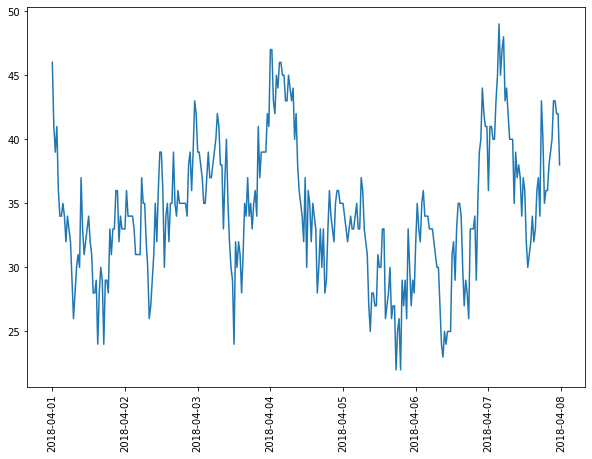

In [81]:
# random.seed(249)
Id=df_new.iloc[random.randint(0,3315)]['Id']
print(Id)

plt.figure(figsize=(10,7))
plt.plot(df_new[df_new['Id']==Id]['date_full'],df_new[df_new['Id']==Id]['tourist'] )
plt.xticks(rotation='vertical')
# df_new[df_new['Id']==Id]['sum']

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47],
 <a list of 48 Text xticklabel objects>)

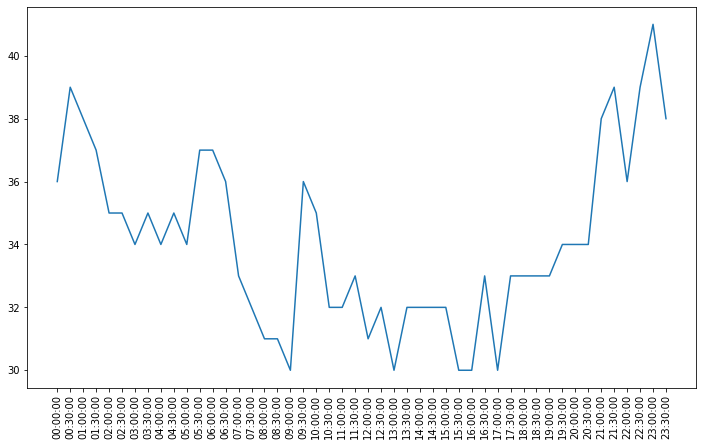

In [113]:
plt.figure(figsize=(12,7))
plt.plot(df_new[df_new['Id']==Id]['time'].unique(),df_new[df_new['Id']==Id].groupby('time')['tourist'].median())
plt.xticks(rotation=90)

In [142]:
df_new_day=df_new[(df_new['time']>='09:00:00')&(df_new['time']<='19:00:00')]

#### Analysing variety of tourist numbers by type of the day

Apart from the part of the day we know from the literature that type of the day ( weekday/weekend) is also an important factor that defines number of tourists. However,  one week is a very small time period to say about the significance of such difference, that is why, for this project we processed weekdays and weekends together.

In order to justify the similarity of week and weekend tourist flows in our data, we built 2 histograms and 2 maps which compare weekday and weekend distribution of tourist numbers in squares. Their distribution looks almost identical and only slightly longer right-tail for weekday makes a difference.

Concerning maps, they, first of all, demonstrate the centricity of tourists flows-  the highest number of tourists concentrates at the city center- for both types of days. Spatial differences between weekday and weekends are not really distinguishable, since small number of squares have differents colors on two maps

In [143]:
df_new_day['is_weekday']=df_new_day['date'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').isoweekday())<6

In [144]:
df_new_day['is_weekday'].value_counts()

True     342463
False    136640
Name: is_weekday, dtype: int64

In [145]:
df_new_day.head()

Id  tourist           date_full        date      time  \
4351110  86711       42 2018-04-01 09:00:00  2018-04-01  09:00:00   
4351111  86711       36 2018-04-01 09:30:00  2018-04-01  09:30:00   
4351112  86711       43 2018-04-01 10:00:00  2018-04-01  10:00:00   
4351113  86711       44 2018-04-01 10:30:00  2018-04-01  10:30:00   
4351114  86711       39 2018-04-01 11:00:00  2018-04-01  11:00:00   

                                                  geometry  \
4351110  POLYGON ((37.60713 55.57683, 37.60714 55.58132...   
4351111  POLYGON ((37.60713 55.57683, 37.60714 55.58132...   
4351112  POLYGON ((37.60713 55.57683, 37.60714 55.58132...   
4351113  POLYGON ((37.60713 55.57683, 37.60714 55.58132...   
4351114  POLYGON ((37.60713 55.57683, 37.60714 55.58132...   

         within_circle_road  is_weekday  
4351110                True       False  
4351111                True       False  
4351112                True       False  
4351113                True       False  
4351114                True       False

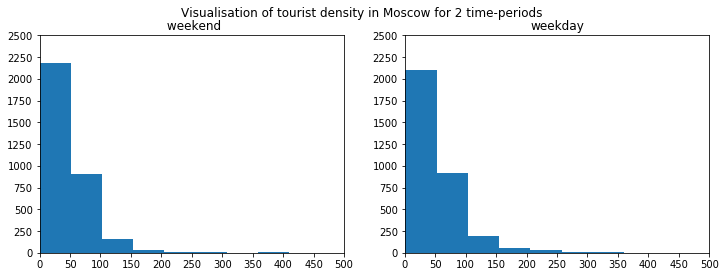

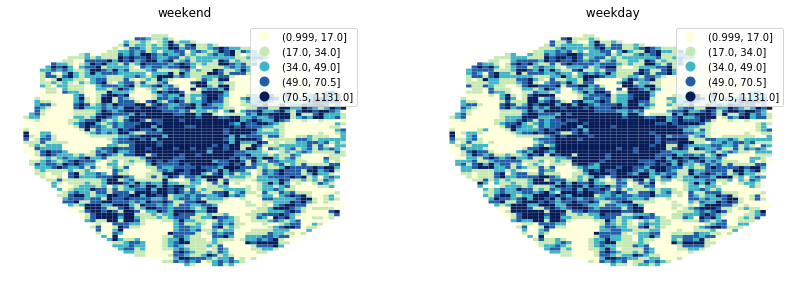

In [147]:
df_moscow=df_new_day.groupby(['Id','is_weekday'])['tourist'].agg('median').reset_index()
df_moscow=gpd.GeoDataFrame(df_moscow.merge(fish, on='Id'))
df_moscow['tourist_perc']=pd.qcut(df_moscow['tourist'], q=5, labels=None)
f, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
plt.suptitle('Visualisation of tourist density in Moscow for 2 time-periods \n', size=12)
for l,j in enumerate(df_moscow['is_weekday'].unique()):
    # select the axis where the map will go
        ax = axs[l]
        bin_num=int(df_moscow[(df_moscow['is_weekday']==j)]['tourist'].max()-df_moscow[(df_moscow['is_weekday']==j)]['tourist'].min())//50
        ax.hist(df_moscow[(df_moscow['is_weekday']==j)]['tourist'], bins=bin_num)
#         ax.set_xticks(np.arange(0,550,50))
        if j:
            ax.set_title('weekday')
        else:
            ax.set_title(' weekend')
        ax.set_xlim(0,500)
        ax.set_xticks(np.arange(0,550,50))
        ax.set_ylim(0,2500)
        ax.set_yticks(np.arange(0,2750,250))
        leg = ax.get_legend()
        leg.set_bbox_to_anchor((0.26, 0.4))
plt.show() 
f, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
for l,j in enumerate(df_moscow['is_weekday'].unique()):
    # select the axis where the map will go
    ax = axs[l]
    df_moscow[(df_moscow['is_weekday']==j)].plot(column='tourist_perc',linewidth=1, ax=ax, colormap='YlGnBu', legend=True)
    ax.set_axis_off()
    if j:
        ax.set_title(' weekday')
    else:
        ax.set_title('weekend')

Given this findings, for further analysis data was aggregated by square without considering the type of the day. As aggregation function median was calculated based on the fact that this metric is robust to outliers 

In [395]:
df_moscow=df_new_day.groupby(['Id'])['tourist'].agg('median').reset_index()

In [396]:
df_moscow=gpd.GeoDataFrame(df_moscow.merge(fish_moscow, on='Id'), crs={'init':'epsg:4326'}, geometry='geometry')

In [164]:
df_moscow.to_file('df_moscow.json', driver='GeoJSON')

In [15]:
df_moscow=gpd.read_file(r'C:\Users\Intra24\Desktop\Glasgow_uni\Group_project\df_moscow.json')

### Processing OSM dataset: Transformations and visualisations

In the dataset from OpenStreetMap there are six categories, four of which are types of accomodation, one is information, and the last one is railway stations.

According to description from Wiki of OpenStreetMap value 'information' includes visitor or tourist centers where a tourist can give a map or any other information concerning to tourist amenities  ( https://wiki.openstreetmap.org/wiki/Key:tourism). In the barchart below we witness extremely high number of information points (over 1000) that makes us thinking that arguably other objects were mistakenly tagged as information.

Text(0.5, 1.0, 'Distribution of facilites in Moscow')

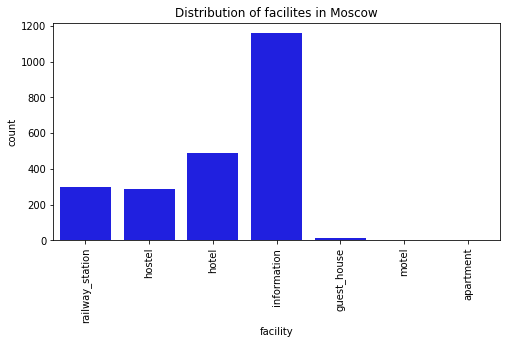

In [16]:
plt.figure(figsize=(8,4))
sns.countplot(df_osm['facility'], color='Blue')
plt.xticks(rotation='vertical')
plt.title('Distribution of facilites in Moscow')

Apparently, it is a true. Among 10 categories of information posts represenred in data only two 'map' and 'office'- mean information points for tourists. All other categories are guideposts, so they have been removed from the dataset

In [19]:
inf=set()
for i in results1.nodes:
    if i.tags['tourism']=='information':
        try:
            inf.add(i.tags['information'])
        except:
            pass
inf

{'board',
 'guidepost',
 'map',
 'office',
 'schedule',
 'screen',
 'stele',
 'tactile_map',
 'tactile_model',
 'terminal'}

In [20]:
df_osm['drop']=df_osm['tags'].apply(lambda x: 0 if  ('office' in x.values() or 'map' in x.values()) or ('information' not in x.values())  else 1)*(df_osm['facility']!='railway_station')

In [21]:
df_osm.groupby('facility')['drop'].count()-df_osm.groupby('facility')['drop'].sum()

facility
apartment            3
guest_house         11
hostel             287
hotel              486
information        315
motel                1
railway_station    297
Name: drop, dtype: int64

Also it is important to notice that tag railway='station' returned not only central stations but also rail stops and subway station, which should be removed from the dataset. However, the structure of dictionary varies from one place to another. That is why, conditions to select only relevant stations were formulated only after looking through all stations' data and identifying items that are unique for central stations.

In [22]:
def get_drop_railway(i):
    if 'subway' not in i.keys() and 'subway' not in i.values():
        try:
              if i['public_transport']=='station':
                    if 'loc_name' in i.keys() or 'alt_name' in i.keys() or 'train' in i.keys():
                        return 0
        except:
            pass
    return 1

In [23]:
df_osm['drop']=df_osm['drop']+df_osm.tags.apply(get_drop_railway)*(df_osm['facility']=='railway_station')

In [24]:
df_osm.loc[1942]

facility                                          information
tags        {'information': 'board', 'start_date': '09.201...
geometry                        POINT (37.6749737 55.5931134)
drop                                                        1
Name: 1942, dtype: object

In [25]:
df_osm.groupby('facility')['drop'].sum()

facility
apartment            0
guest_house          0
hostel               0
hotel                0
information        844
motel                0
railway_station    285
Name: drop, dtype: int64

In [26]:
df_osm.groupby('facility')['drop'].sum().sum()

1129

Summing up, 1129 observations have been dropped from the OSM dataset

In [286]:
df_osm_up=df_osm[df_osm['drop']==0]

Next, we would like to distinguish the type of information post, that is why, we specified the exact type of information in 'facility' column. Meanwhile, for purpose of modelling the type of accomodation does not metter. We therefore replaced type of accomodation with the word 'accomodation'. Finally, the dataset contains four categories.

In [287]:
df_osm_up.loc[~df_osm_up['facility'].isin(['information','railway_station' ]), 'facility']='accomodation'

df_osm_up.loc[df_osm_up['facility']=='information','facility']=df_osm_up.loc[df_osm_up['facility']=='information'].tags.apply(lambda x: 'map' if x['information']=='board' else x['information'] )

Text(0.5, 1.0, 'Distribution of facilites in Moscow')

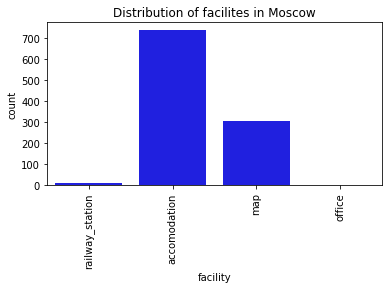

In [288]:
plt.figure(figsize=(6,3))
sns.countplot(df_osm_up['facility'], color='Blue')
plt.xticks(rotation='vertical')
plt.title('Distribution of facilites in Moscow')

There are only three tourist offices in Moscow, as such, their location can be explained by mapping them on the map of Moscow. From the maps below we can see that one office is located at the city center, another is on the square of Three railways and Sokolniki park, and there is  a remote one that doesn't suite any popular place. Checking it persice location on map we can see the error in data, as  this center belong to the Moscow University of Construction, hence it is not for tourists. We therefore revomed it from dataset 

In [290]:
df_map=df_osm_up[df_osm_up['facility'].isin(['map','office'])]
df_map['lat']=df_map.geometry.apply(lambda i: i.y)
df_map['long']=df_map.geometry.apply(lambda i: i.x)

In [289]:
df_osm_up[df_osm_up['facility'].isin(['map','office'])]['facility'].value_counts()

map       305
office      3
Name: facility, dtype: int64

In [291]:
m_2 = folium.Map(location=[  55.75, 37.65], tiles='cartodbpositron', zoom_start=10)

# Add points to the map
for idx, row in df_map[df_map['facility']=='office'].iterrows():
    Marker([row['lat'], row['long']]).add_to(m_2)

# Display the map
m_2

In [1340]:
df_osm_up[df_osm_up['facility'].isin(['office'])]

facility                                               tags  \
429    office  {'information': 'office', 'name': 'Мосгорсправ...   
764    office  {'information': 'office', 'tourism': 'informat...   
1119   office  {'description': 'Информационный центр', 'infor...   

                       geometry  drop  within_circle_road  
429   POINT (37.61213 55.75852)     0                True  
764   POINT (37.67762 55.79359)     0                True  
1119  POINT (37.69394 55.85850)     0                True

In [1345]:
# visualising office locations in large scale
f, ax = plt.subplots(figsize=(5,5))
df_osm_up[df_osm_up['facility'].isin(['office'])].to_crs(epsg='3857').plot(ax=ax, color='red')
mplleaflet.display(fig=f, crs={'init':'epsg:3857'})

In [1346]:
df_osm_up.drop(1119, inplace=True)

There are 305 information maps in the city Distribution of them is quite sparse, however the more than half of them is located in the city center. The least number of maps is in south-west part of Moscow

In [292]:
m_5 = folium.Map(location=[  55.75, 37.65], tiles='cartodbpositron', zoom_start=10 )
mc = MarkerCluster()
for idx, row in df_map[df_map['facility']=='map'].iterrows():  
    mc.add_child(Marker([row['lat'], row['long']]))
m_5.add_child(mc)
m_5

In [295]:
df_fac=df_osm_up[df_osm_up['facility']=='accomodation']
df_fac['lat']=df_fac.geometry.apply(lambda i: i.y)
df_fac['long']=df_fac.geometry.apply(lambda i: i.x)

Mapping accomodations shows that the most of them is also located in the city center. So we can suggest that there maps will be highly demanded by tourists. However the least equiped area is south-east (only 11 hotels), while the south-west has a 28 places for staying. It means that in south-west area there is possibly an insufficient volume of infrastructure for tourists. 

In [296]:
m_3 = folium.Map(location=[  55.75, 37.65], tiles='cartodbpositron', zoom_start=10 )
mc = MarkerCluster()
for idx, row in df_fac.iterrows():  
    mc.add_child(Marker([row['lat'], row['long']]))
m_3.add_child(mc)

# Display the map
m_3
# plt.title('Mapping facilities potentially attracted tourists Moscow')

### Processing Moscow attractions dataset: Transformations and visualisations

Processing of Moscow attractions data was focus on removing unrelevant objects and translating them in English. Due to all objects' categories are stored in Russian ( field 'Caption), dictionary was manually created to map russian and english names. Also some categories were removed such as libraries, education centers, plaques, animals in Moscow zoo etc.  The final dataset contains 28 unique categories of attractions and 17018 unique objects

In [44]:

drop_values=['Границы зон охраны объектов культурного наследия','Учреждения, осуществляющие управленческие функции','Объекты, вошедшие в программу дней исторического и культурного наследия',
       'Лауреаты конкурса Правительства Москвы «Московская реставрация»','Результаты контроля за состоянием благоустройства мест отдыха с купанием',
       'Объекты туристического показа и объекты гостиничного хозяйства города Москвы, приспособленные для лиц с ограниченными возможностями здоровья и людей пожилого возраста',
       'Туристский событийный календарь города Москвы на 2019 год','Дома культуры и клубы',
       'Зимние активности парков, подведомственных Департаменту культуры города Москвы',
             'Перечень пешеходных туристических маршрутов Москвы','Границы территорий объектов культурного наследия',
       'Перечень автобусных туристических маршрутов Москвы',
             'Перечень туристско-информационных центров Москвы',
       'Археологические находки на реконструируемых улицах',
       'Мемориальные доски города Москвы',
       'Интерактивная карта учреждений культуры города Москвы','Библиотеки',
       'Места проведения фестиваля «Московское Лето. Цветочный Джем»',
       'Образовательные учреждения', 'Перечень видов животных, обитающих в Московском Зоопарке',
             'Мероприятия, организованные при поддержке Департамента культуры города Москвы',
              'Залы теннисные', 'Залы тренажерные',
             'Аттракционы в торговых центрах и комплексах','Бассейны плавательные открытые',
             'Детские развивающие центры','Бассейны плавательные крытые',
             
        ]
open_moscow=df_attract[~df_attract['Caption'].isin(drop_values)]

dic_rus_eng={'Кинотеатры':'cinema', 'Аттракционы в скверах и парках':'rides',
       'Выставочные залы':'exhibition_hall', 'Концертные организации':'concert_venue', 'Музеи':'museum',
       'Объекты культурного наследия':'cultural_heritage', 'Театры':'theatres',
       'Поля регбийные':'regby_field', 'Поля футбольные':'football_field', 'Стрелковые тиры':'shooting_gallery',
       'Стрельбища':'shooting_gallery', 
       'Спортивные площадки':'sport_ground', 
       'Площадки пейнтбольные':'paintball_ground', 'Тренажерные городки (воркауты)':'sport_ground',
       'Поля конно-спортивные для конкура и выездки':'ride_station',
        'Места для пикника':'picnic_place',
       'Площадки для городошного спорта':'sport_ground', 'Пешеходные зоны':'pedestrian_area',
       'Ледовые поля (крытые)':'ice_field',
       'Площадки спортивные универсальные в парках':'sport_ground',
       'Универсальные зоны отдыха в парках':'park_relax_zone',
       'Автодромы спортивные крытые':'motor-racing circuit', 'Автодромы спортивные открытые':'motor-racing circuit',
       'Места катания на лошадях':'ride_station', 'Скалодромы крытые':'climbing_center',
       'Скалодромы открытые':'climbing_center', 'Детские игровые площадки в парках':'playground',
       'Парковые территории':'park', 'Танцевальные площадки в парках':'mus_dance_venue_park',
       'Музыкальные площадки в парках':'mus_dance_venue_park',
       'Места для досуга и отдыха с детьми':'family_places', 'Аквапарки':'aquapark',
       'Ботанические сады':'botanic_garden',
       'Залы спортивные':'sport_ground',
       'Перечень скульптур под открытым небом, расположенных на территории учреждений, подведомственных Департаменту культуры города Москвы'
             :'sculpture',
       'Перечень смотровых площадок, оборудованных стационарными биноклями':'view_point'}

open_moscow['Caption']=open_moscow['Caption'].map(dic_rus_eng)


In [48]:
open_moscow['Caption'].nunique()

28

The diagram shows that cultural heritage,sport grounds and kids are the most numerous groups of attractions.Other categories have less than 1000 objects in them

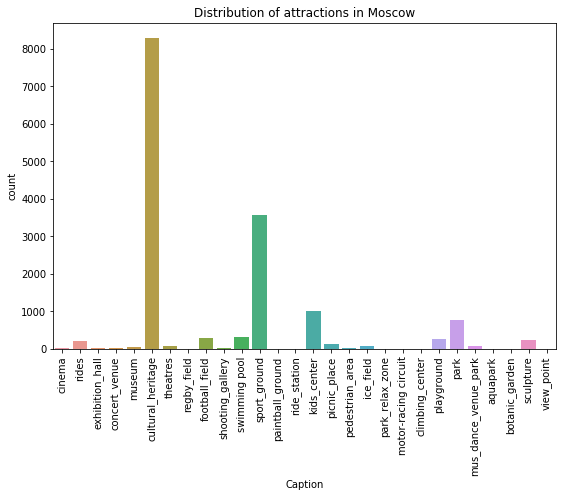

In [441]:
plt.figure(figsize=(9,6))
sns.countplot(open_moscow['Caption'])
plt.title('Distribution of attractions in Moscow')
plt.xticks(rotation='vertical');

Mapping demonstrates that almost all area of city is covered by different type of attractions.That is why, it is impossible to identify from the map which of them attract tourist the most.

However when we visualise cultural heritage separately we see that its distribution is similar to those we witnessed when visualizing information maps, accomodations and tourist density. They also concentrate at city center and have a big clusters of objects in north-west 

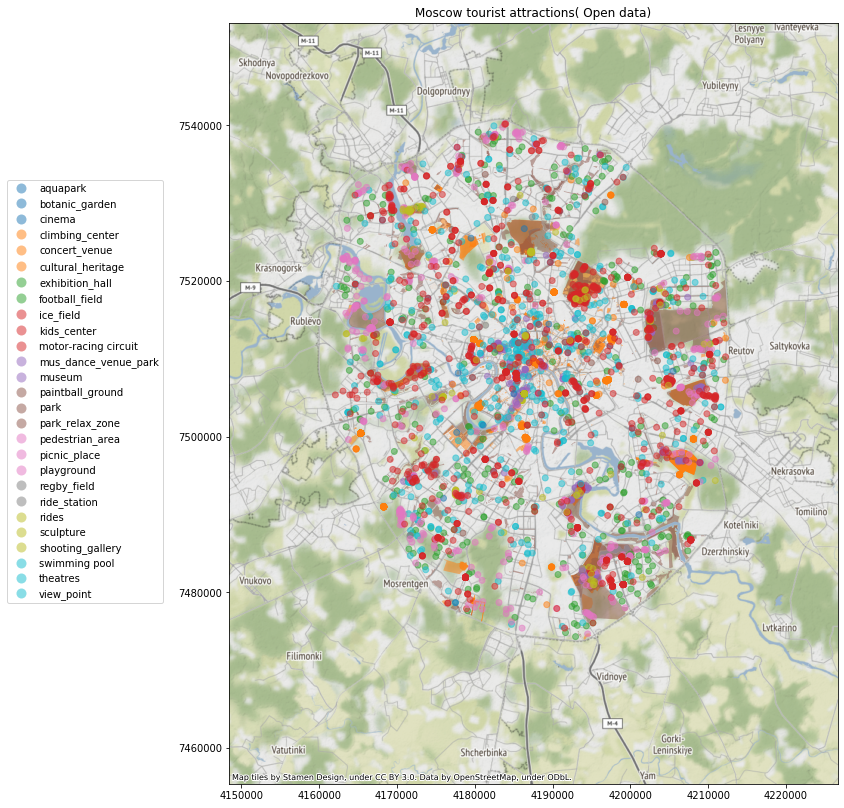

In [862]:
ax=open_moscow3857[open_moscow3857['Caption']!='sport_ground'].plot(column='Caption', figsize=(14,14), legend=True, alpha=0.5)
ax.set_title('Moscow tourist attractions( Open data)')
leg = ax.get_legend()
leg.set_bbox_to_anchor((-0.1, 0.8))
ctx.add_basemap(ax);

In [308]:
open_moscow['lat']=open_moscow.geometry.apply(lambda i: i.centroid.y)
open_moscow['long']=open_moscow.geometry.apply(lambda i: i.centroid.x)

In [310]:
m_5 = folium.Map(location=[ 55.75, 37.65], tiles='cartodbpositron', zoom_start=10)

# Add a heatmap to the base map
HeatMap(data=open_moscow[open_moscow['Caption']=='cultural_heritage'][['lat', 'long']], radius=10).add_to(m_5)

# Display the map
m_5

## Merging data& Feature engineering

The next step is to match all data together. In order to obtain variables from facilities and attractions datasets the number of their observations was calculated for each 500x500m square of Moscow using different buffers. In particular, the next steps were carried out:
 - Coordinate reference system was changed to transform coordinates into meters
 - 500, 1000, 2000 metres buffers were calculated for every centroid of square
 - for every buffer a new dataset was created where the index is a square ID and columns are number of facilities located within buffer
 - Datasets were spatially joined with fishnet dataset
 - Pivot table was built to get number of every facility as a feature
 
The radius of buffer was chosed based on suggestion that they relates to 7 minutes, 15 minutes and 30 minutes of walking. The idea for such approach was found in the work of Lianfa Li (2019). 

In [50]:
df_moscow.set_geometry('geometry', inplace=True)

In [51]:
df_moscow['geometry_1000']=df_moscow.to_crs(epsg='3857').buffer(1000)
df_moscow['geometry_2000']=df_moscow.to_crs(epsg='3857').buffer(2000)
df_moscow['geometry_500']=df_moscow.to_crs(epsg='3857').geometry

In [902]:
df_osm3857=df_osm_up.to_crs(epsg='3857')

In [99]:
open_moscow3857=open_moscow.to_crs(epsg='3857')

In [703]:
def get_features_buffer( buf): # create dataset for every buffer and then match it with fishnet
    col='geometry_'+str(buf)
    df_moscow_buf=gpd.GeoDataFrame(df_moscow[['Id','tourist',col]], crs={'init':'epsg=3857'}, geometry=col)
#     print (df_moscow_buf.shape)
    df_full1=gpd.sjoin(left_df=df_moscow_buf, right_df=df_osm3857[['geometry','facility']], how='left',op='contains')
#     print (df_full1.shape)
    df_full2=gpd.sjoin(left_df=df_moscow_buf, right_df=open_moscow3857[['geometry','Caption']], how='left',op='intersects')
#     print (df_full2.shape)
    df_full=pd.concat([df_full1, df_full2.rename(columns={'Caption':'facility'})])
    print(df_full[pd.isnull(df_full['index_right'])]['Id'].nunique())
    df_moscow_full=df_full[['Id','facility','index_right','tourist']].pivot_table(columns=['facility'], index=['Id','tourist'], values='index_right', aggfunc='count').fillna(0)
    print(df_moscow_full.shape)
    df_moscow_full=df_moscow_full.reset_index(level=1)
    new_names=[i+'_'+str(buf) for i in df_moscow_full.columns[1:]]
#     print (new_names)
    df_moscow_full.rename(columns=dict(zip(df_moscow_full.columns[1:],new_names)), inplace=True)
    return df_moscow_full

In [704]:
df_moscow_features500= get_features_buffer(500)

2886
(2531, 32)


In [107]:
df_moscow_features1000= get_features_buffer(1000)
df_moscow_features2000= get_features_buffer(2000)

In [108]:
df_moscow_features=df_moscow_features500.join(df_moscow_features1000[df_moscow_features1000.columns[1:]]).join(df_moscow_features2000[df_moscow_features2000.columns[1:]])

In [691]:
df_moscow_features500.shape

(2531, 33)

In [104]:
df_moscow_features.to_csv('df_moscow_features.csv')

### Visualisation of relationships between features

Now when data is matched, visualisations are provided to identify relationships between different features

From building the heatmap of correlation matrix we observe the negative correlation between football field and cultural heritage, positive correlation between tourist and accomodations, museum and cultural heritage, rides and music and dance places in park. It is reasonable, as both activities are most probably located in parks. Other features are weekly correlated.

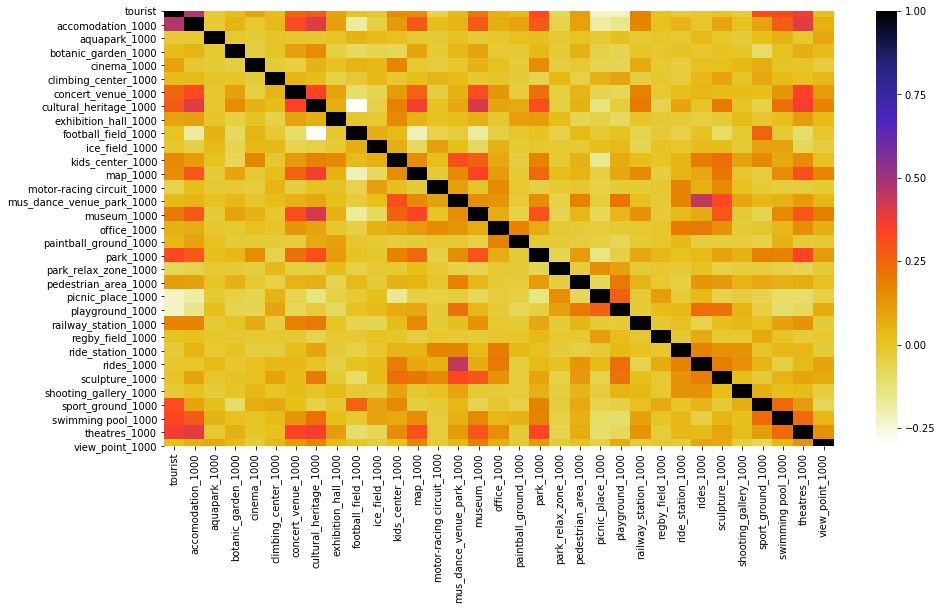

In [213]:
plt.figure(figsize=(15,8))
          
_=sns.heatmap(df_moscow_features[df_moscow_features1000.columns].corr(method='spearman'), cmap='CMRmap_r' )

Scatters plots below help to identify relations of some features in more details. For example, there is a certain postive correlation between number of tourists and number of attractions within 1000 metres around. Also museums an cultural heritage  also positively correlates, while park and museums are distributed  almost independently from each other

Text(0.5, 1.0, '  tourist - accomodation_1000')

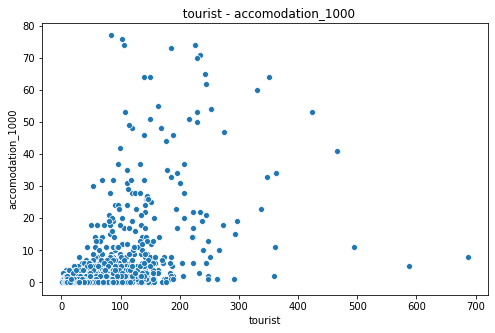

In [1358]:
sns.scatterplot(data=df_moscow_features[df_moscow_features1000.columns][['tourist','accomodation_1000']], x='tourist',y='accomodation_1000' )
plt.title ( '  tourist - accomodation_1000')

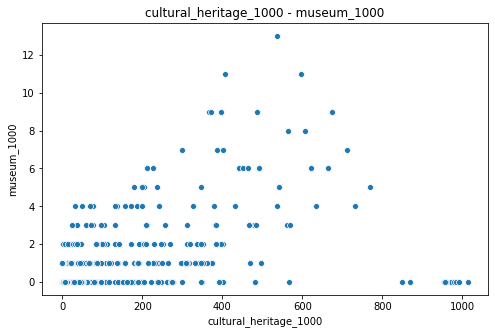

In [1359]:
sns.scatterplot(data=df_moscow_features[df_moscow_features1000.columns][['cultural_heritage_1000','museum_1000']], x='cultural_heritage_1000',y='museum_1000' )
plt.title ('cultural_heritage_1000 - museum_1000' );

Text(0.5, 1.0, 'park_1000 -museum_1000')

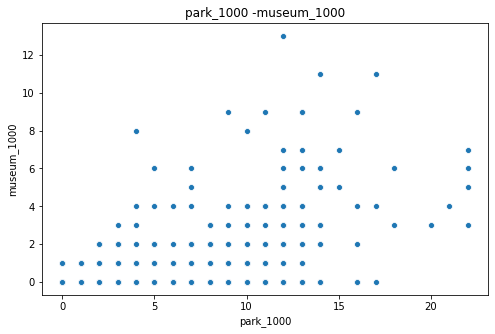

In [1360]:
sns.scatterplot(data=df_moscow_features[df_moscow_features1000.columns][['park_1000','museum_1000']], x='park_1000',y='museum_1000' )
plt.title('park_1000 -museum_1000')

In [220]:
pd.qcut(df_moscow_geo, q=5).value_counts()

(53.0, 77.0]     411
(0.999, 23.0]    410
(23.0, 39.0]     409
(39.0, 53.0]     402
(77.0, 687.0]    392
Name: tourist, dtype: int64

Next, we map tourist maps versus squres with high tourist density ( 5th percentile), using quantiles for the last one. We can notice that there are a lot of blue dark squares ( with density over 146) that are not covered by any maps. It says about non-optimal infromation maps distribution

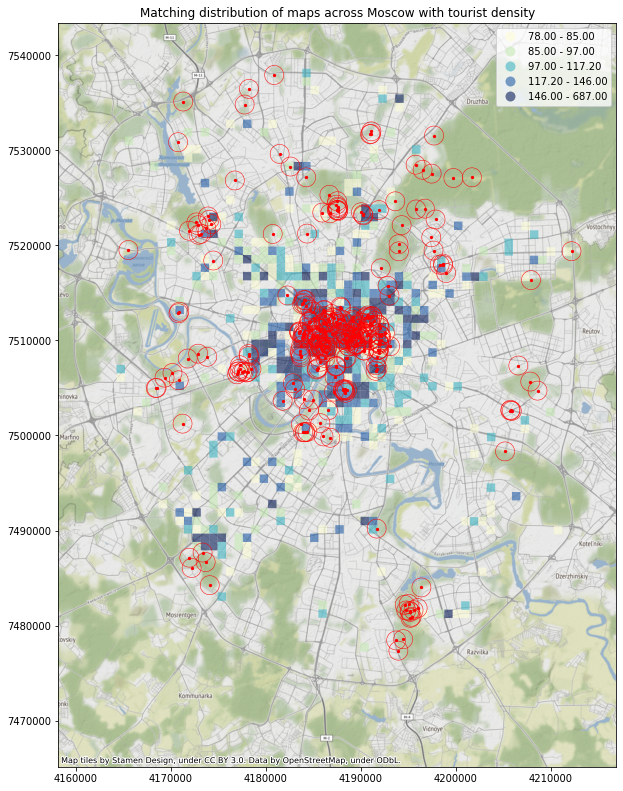

In [1076]:
fig,ax=plt.subplots( figsize=(10,15))
df_moscow_geo[df_moscow_geo['tourist']>77].to_crs(epsg='3857').plot(alpha=0.6, ax=ax, column='tourist', scheme='Quantiles', cmap='YlGnBu', legend=True )
df_osm3857[df_osm3857['facility']=='map'].plot(ax=ax , color='red', markersize=5)
df_osm3857[df_osm3857['facility']=='map'].buffer(1000).plot(ax=ax ,  color='none', linewidth=0.5, edgecolor='red')
ax.set_title('Matching distribution of maps across Moscow with tourist density')
ctx.add_basemap(ax)

## Data analysis

### Defining determinants of tourist density using XGBoost

In order to define the list of factors that attract tourist to places in Moscow we build XGBoost regressor. According to XGBoost guidebook, this model is widely recognised as a good method to predict importance of factors, that is exactly what we need (https://buildmedia.readthedocs.org/media/pdf/xgboost/latest/xgboost.pdf ) 

Although this model is not adapted for spatial problems, to deal with it we created additional features for this model as latitute and longtitude( the idea taken from Lianfa Li). If the location of places by itself significantly influence its popularity we would be able to recognise it as  these features will be important

In [110]:
df_moscow_features.reset_index(inplace=True)

In [111]:
fish_moscow['lat']=fish_moscow.geometry.centroid.apply(lambda x: x.x)
fish_moscow['long']=fish_moscow.geometry.centroid.apply(lambda x: x.y)

In [112]:
df_moscow_features=df_moscow_features.merge(fish_moscow[['Id','long','lat']], on='Id')

In [627]:
import xgboost as xgb
# from sklearn.cross_validation import * 
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, recall_score, precision_score, accuracy_score

In [172]:
df_moscow_features.isnull().mean().sum()

0.0

### XGBoost

Target variable - number of tourists in square
Independent variables - features with number of facilities and attractions in 500,1000 and 2000 metres

In [123]:
ind_vars=[ i for i in df_moscow_features.columns[2:] if 'map' not in i and 'office' not in i and 'swimming_pool' not in i and 'cinema' not in i]

X= df_moscow_features[ind_vars]
Y= df_moscow_features['tourist']

X_train, X_test,Y_train, Y_test=train_test_split(X, Y, train_size=0.8)

In [145]:
X_train.to_csv('X_train.csv')
X_test.to_csv('X_test.csv')
Y_train.to_csv('Y_train.csv')
Y_test.to_csv('Y_test.csv')

First we choose random parametres for our grid search in order to get baseline and then we specify them

In [114]:
parameters={
    'n_estimators' : np.arange(5,25,5),
    'min_child_weight': [2, 5, 10],
    'gamma': [ 0.5,1, 2, 2.5],
    'subsample': [0.4,0.6,0.8],
    'colsample_bytree': [0.4,0.6,0.8],
    'max_depth': np.arange(3,8,1)        
}

# {'min_child_weight':[4,5], 'gamma':[i/10.0 for i in range(3,6)],  'subsample':[i/10.0 for i in range(6,11)],
# 'colsample_bytree':[i/10.0 for i in range(6,11)], 'max_depth': [2,3,4]}

In [102]:
xgb_model=xgb.XGBRegressor( )

In [641]:
# from sklearn import metrics as met
# met.SCORERS.keys()

Trying on different parameters shows that model is getting overfitted fast. The big lap between train and test scores approve it. While train R^2 keeps raising, the test R^2 score goes down

In [87]:
gs = GridSearchCV(xgb_model, parameters, n_jobs=5, 
                    cv=3,
#                   StratifiedKFold(n_splits=5, shuffle=True), 
                   scoring='r2',
                   refit=True)

# clf.fit(train[features], train["QuoteConversion_Flag"])

gs.fit(X_train, Y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster=None,
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=0.8, gamma=2, gpu_id=-1,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.300000012, max_delta_step=0,
                                    max_depth=7, min_child_weight=2,
                                    missing=nan, monotone_constraints=None,
                                    n_estim...
                                    tree_method=None, validate_parameters=False,
                                    verbosity=None),
             iid='warn', n_jobs=5,
             param_grid={'colsample_bytree': [0.4, 0.6, 0.8],
                         'gamma': [0.5, 1, 2, 2.5],
                         'max_depth': array([

In [88]:
gs.best_params_

{'colsample_bytree': 0.6,
 'gamma': 0.5,
 'max_depth': 6,
 'min_child_weight': 5,
 'n_estimators': 20,
 'subsample': 0.8}

We visualise how quality of model changed depending of change of different parametres in order to define the range of the best one and train model again.
For example,we  can see that trains score is increasing with the increase of number of trees ( n-estimators)  and maximal depth of trees ( before point 6) while it is decreasing with increase of minimal number of observations in leafs ( min_child_weight)

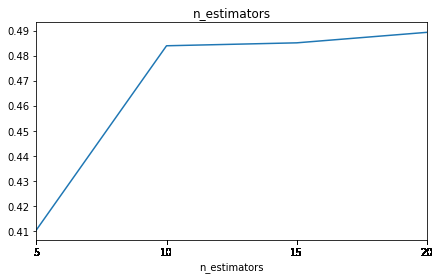

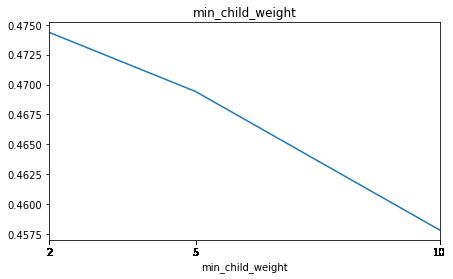

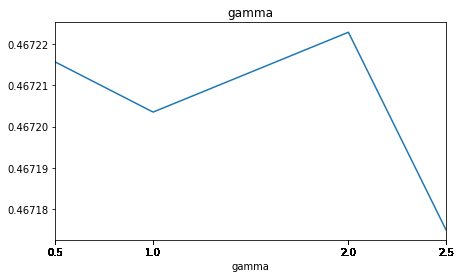

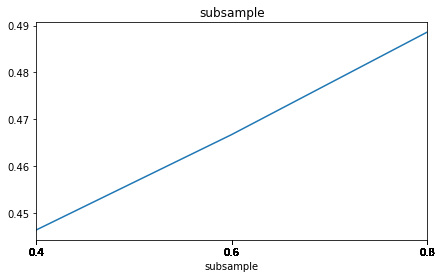

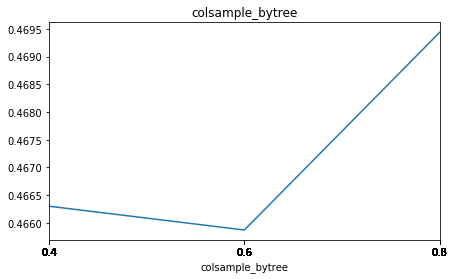

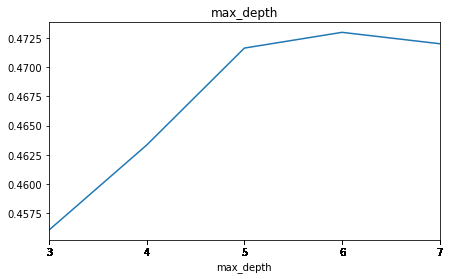

In [89]:
def visual_change(param, gs):
    plt.figure(figsize=(7,4))
    df_estim=pd.DataFrame([ d[param] for d in gs.cv_results_['params']] , columns=[param])
    res=gs.cv_results_['mean_test_score']
    df_estim['mts']=res
    df_estim.groupby(param)['mts'].mean().plot()
    plt.title(param)
    plt.xticks(df_estim[param].values)

for  par in list(parameters.keys()):
    try:
        visual_change(par, gs)
    except:
        pass

In [659]:
def get_scores(x,y, xgb, reg=True):
    y_train_predict=xgb.predict(x)
    if reg:
        print('r2',r2_score(y,y_train_predict ))
        print('rmse', np.sqrt(mean_squared_error(y,y_train_predict )))
    else:
        print('roc-auc score', roc_auc_score(y,y_train_predict))
        print('accuracy score',accuracy_score(y,y_train_predict))
        print('precision score', precision_score(y,y_train_predict))
        print('recall score', recall_score(y,y_train_predict))

We got a high quality of model in train dataset - 85% of variation of target variable is explained by independent variables, but low quality on test score where coefficient of determination is only 43% 

In [90]:
get_scores(X_train, Y_train, gs)

r2 0.8501125902642137
rmse 18.892289042106366


Therefore, in order to check the rate of popular touristic area uncovered by maps we overlayed to maps, specifying method of spatial overlay as 'difference'. On the map below 

In [91]:
get_scores(X_test, Y_test, gs)

r2 0.4303031819032185
rmse 36.40802843905652


In order to improve results on test dataset we will consider the test score while selecting parameters. Controlling of test results has been implemented by using ParameterGrid modul with a loop together 

In [74]:
from sklearn.model_selection import ParameterGrid

In [132]:
parameters={
    'n_estimators' : np.arange(10,18,1),
    'min_child_weight': [2, 3,4],
    'gamma': [2],
    'subsample': [0.6,0.8, 1],
    'colsample_bytree': [0.8],
    'max_depth': [5,6,7,8]        
}

In [133]:
train_r2=[]
test_r2=[]
max_test=0
max_test_i=0
for i,pars in enumerate(ParameterGrid(parameters)):
    if i%6==0 : print(pars)
    xgb_model=xgb.XGBRegressor()
    xgb_model.set_params(**pars)
#     print(xgb_model.get_params)
    xgb_model.fit(X_train, Y_train )
    y_train_predict=xgb_model.predict(X_train)
    y_test_predict=xgb_model.predict(X_test)
    if r2_score(Y_test,y_test_predict )>max_test:
        max_test_i=i
        max_test=r2_score(Y_test,y_test_predict )
    test_r2.append(r2_score(Y_test,y_test_predict ))
    train_r2.append(r2_score(Y_train,y_train_predict ))

{'colsample_bytree': 0.8, 'gamma': 2, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 10, 'subsample': 0.6}
{'colsample_bytree': 0.8, 'gamma': 2, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 12, 'subsample': 0.6}
{'colsample_bytree': 0.8, 'gamma': 2, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 14, 'subsample': 0.6}
{'colsample_bytree': 0.8, 'gamma': 2, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 16, 'subsample': 0.6}
{'colsample_bytree': 0.8, 'gamma': 2, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 10, 'subsample': 0.6}
{'colsample_bytree': 0.8, 'gamma': 2, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 12, 'subsample': 0.6}
{'colsample_bytree': 0.8, 'gamma': 2, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 14, 'subsample': 0.6}
{'colsample_bytree': 0.8, 'gamma': 2, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 16, 'subsample': 0.6}
{'colsample_bytree': 0.8, 'gamma': 2, 'max_depth': 5, 'min_child_weight': 4, 'n_

When depth is high model gets overfitted because as we can see the score is decreasing after point 6. Meanwhile, the higher number of estimators leads to higher score both on training and test datasets. Also training dataset is probably too small to divide it by subsamples because on fifth graph we see that the highest score is achieved both on training and test datasets when whole sample is used. Last, while we do not want min_child_weight to be too small to avoid overfitting, we also notice that that result gets worse after '3' is reached.

The final parameters for our model are following: 
     - 'subsample': 1,
     - 'n_estimators': 12,
     - 'min_child_weight': 3,
     - 'max_depth': 8,
     - 'gamma': 2,
     - 'colsample_bytree': 0.8

n_estimators
min_child_weight
gamma
subsample
colsample_bytree
max_depth


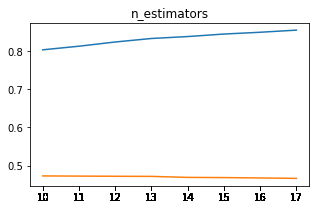

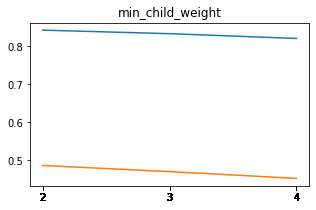

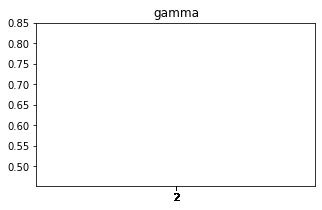

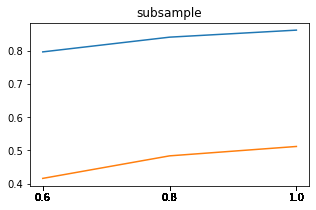

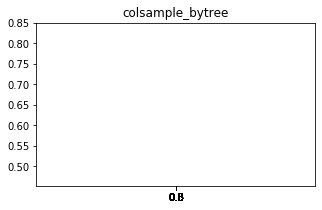

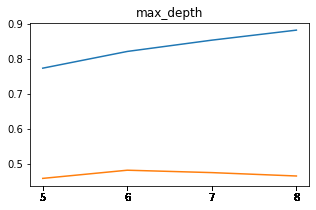

In [134]:
def visual_change_p(param, train,test):
    print(param)
    plt.figure(figsize=(5,3))
    df_estim=pd.DataFrame([ d[param] for d in ParameterGrid(parameters)] , columns=[param])
    df_estim['train']=train
    df_estim['test']=test
    plt.plot(df_estim.groupby([param])['train'].mean())
    plt.plot(df_estim.groupby([param])['test'].mean())
    plt.title(param)
    plt.xticks(df_estim[param].values)

for  par in list(parameters.keys()):
#     try:
        visual_change_p(par, train_r2, test_r2)
#     except:
#         pass

In [135]:
params_fin=ParameterGrid(parameters)[max_test_i]

In [137]:
params_fin

{'subsample': 1,
 'n_estimators': 12,
 'min_child_weight': 3,
 'max_depth': 8,
 'gamma': 2,
 'colsample_bytree': 0.8}

In [193]:
xgb_model=xgb.XGBRegressor()
xgb_model.set_params(**params_fin)
xgb_model.fit(X_train, Y_train )

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=2, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=8,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             n_estimators=12, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

Looking at R^2 lets us find out that we revealed as train as test score and now more than half of variation of target variable on test dataset is explained by independent variables. That is good result when only one week of observations is available

In [194]:
get_scores(X_train, Y_train, xgb_model)

r2 0.9075252490062886
rmse 15.366869705764614


In [195]:
get_scores(X_test, Y_test, xgb_model)

r2 0.5549486132363075
rmse 29.37464209794498


In [196]:
dic_feat=dict(zip(X_train.columns,xgb_model.feature_importances_*100))

Next we visualize feature importance using importance type 'gain'(the average training loss reduction gained when using a feature for splitting). As we can see the most important features are accomodations, railway stations, theatres, park venues, shooting galleries and museums.  Coordinates didn't get among important features that means that closeness of attractions and facilities determine number of tourist better than location itself

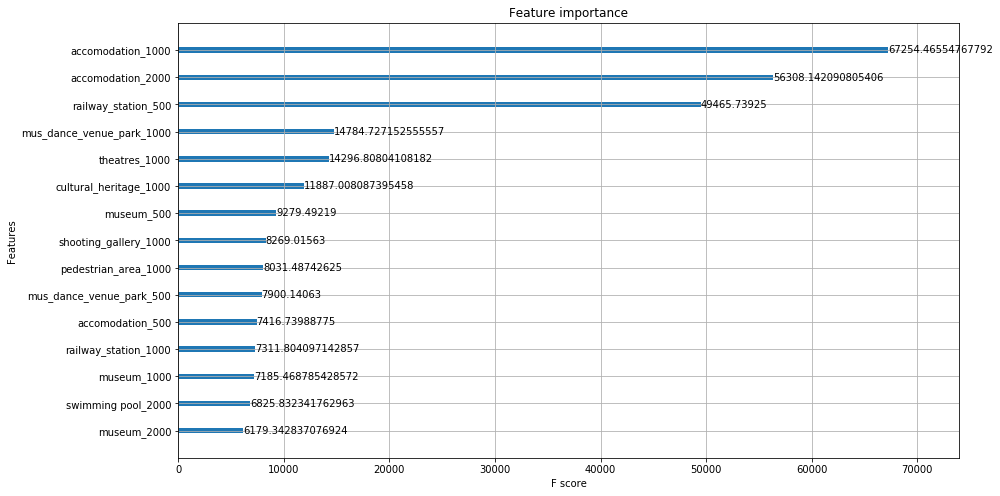

In [368]:
# plt.figure(figsize=(13,10))
plt.rcParams['figure.figsize'] = [14, 8]
xgb.plot_importance(xgb_model, importance_type='gain', max_num_features=15)
plt.show()

In [779]:
df_moscow_features['predict_tourist']=xgb_model.predict(X)

From the maps below we can see that prediction decribes density well

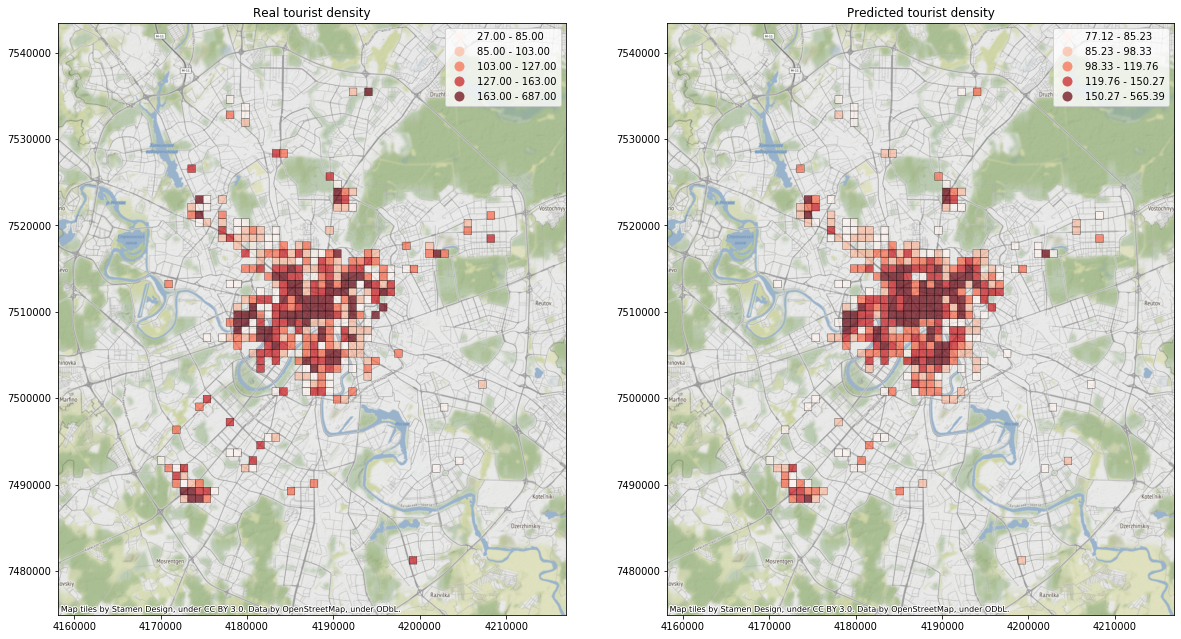

In [858]:
fig,axs=plt.subplots( nrows=1, ncols=2, figsize=(20,18))
ax1=axs[0]
ax2=axs[1]
df_crowded.to_crs(epsg='3857').plot(column='tourist', scheme='Quantiles', k=5, legend=True,alpha=0.7, ax=ax1,edgecolor='black', linewidth=0.4, cmap='Reds')
df_crowded.to_crs(epsg='3857').plot(column='predict_tourist', scheme='Quantiles', k=5, legend=True,alpha=0.7, ax=ax2, cmap='Reds', linewidth=0.4, edgecolor='black')
ctx.add_basemap(ax1)
ax1.set_title('Real tourist density')
ax2.set_title('Predicted tourist density')
ctx.add_basemap(ax2)

In [378]:
list_cols=dict(sorted(dic_feat.items(), key=lambda kv: kv[1], reverse=True)[:10]).keys()

In [379]:
params_fin

{'subsample': 1,
 'n_estimators': 12,
 'min_child_weight': 3,
 'max_depth': 8,
 'gamma': 2,
 'colsample_bytree': 0.8}

In [405]:
 from sklearn import tree

Next we build decision tree map to get simple rules that will help authorities to undersand where in the future new information facilities should be located. From the diagram below we can see that accomodations in 2000 metres (>=9) and cultural heritage within 1000 ( >1) are key parametres

In [654]:
clf=tree.DecisionTreeClassifier( criterion='gini', max_depth=2, min_samples_leaf=2, class_weight={0:1, 1:3} )

In [655]:
clf.fit(X_train_bin, Y_train_bin)

DecisionTreeClassifier(class_weight={0: 1, 1: 3}, criterion='gini', max_depth=2,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [660]:
get_scores(X_train_bin, Y_train_bin, clf, False)

roc-auc score 0.7276348039215688
accuracy score 0.8670948616600791
precision score 0.7286245353159851
recall score 0.5


In [661]:
get_scores(X_test_bin, Y_test_bin, clf, False)

roc-auc score 0.7502866213951848
accuracy score 0.8579881656804734
precision score 0.7619047619047619
recall score 0.5517241379310345


In [152]:
# import os
# os.environ["PATH"] += os.pathsep + 'C:/graphviz/release/bin/'

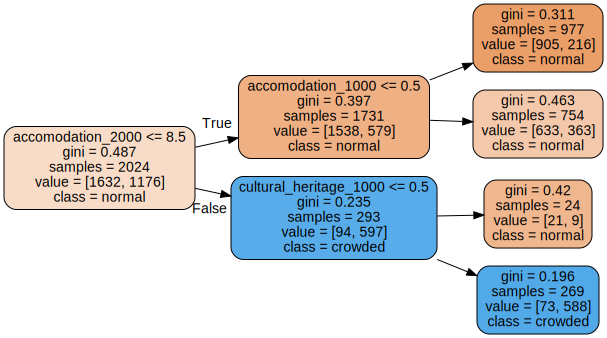

In [658]:
import pydotplus
from graphviz import Source
dot =  tree.export_graphviz(clf, out_file=None, feature_names=list(list_cols), rotate=True, class_names=['normal','crowded'], rounded=True, filled=True)
pdot = pydotplus.graph_from_dot_data(dot)
# Access element [0] because graph_from_dot_data actually returns a list of DOT elements.
pdot.set_graph_defaults(size = "\"10,15\"")
graph = Source(pdot.to_string())
graph


In [652]:
376/2

188.0

Final condition: accomodation_2000>=9 and cultural_heritage_1000>=1

In [665]:
df_moscow_features[(df_moscow_features['accomodation_2000']>=9)&(df_moscow_features['cultural_heritage_1000']>=1)].shape

(353, 100)

In [683]:
df_moscow_features['is_crowded']=1*(df_moscow_features['accomodation_2000']>=9)*(df_moscow_features['cultural_heritage_1000']>=1)

In [780]:
df_moscow_features['is_predict_crowded']=1*(df_moscow_features['predict_tourist']>77)

In [690]:
df_moscow_features.shape

(2531, 101)

It looks more solid but still is very close to the distribution predicted by XGBoost. So in order to not check in the future the rule with two conditions can be used 

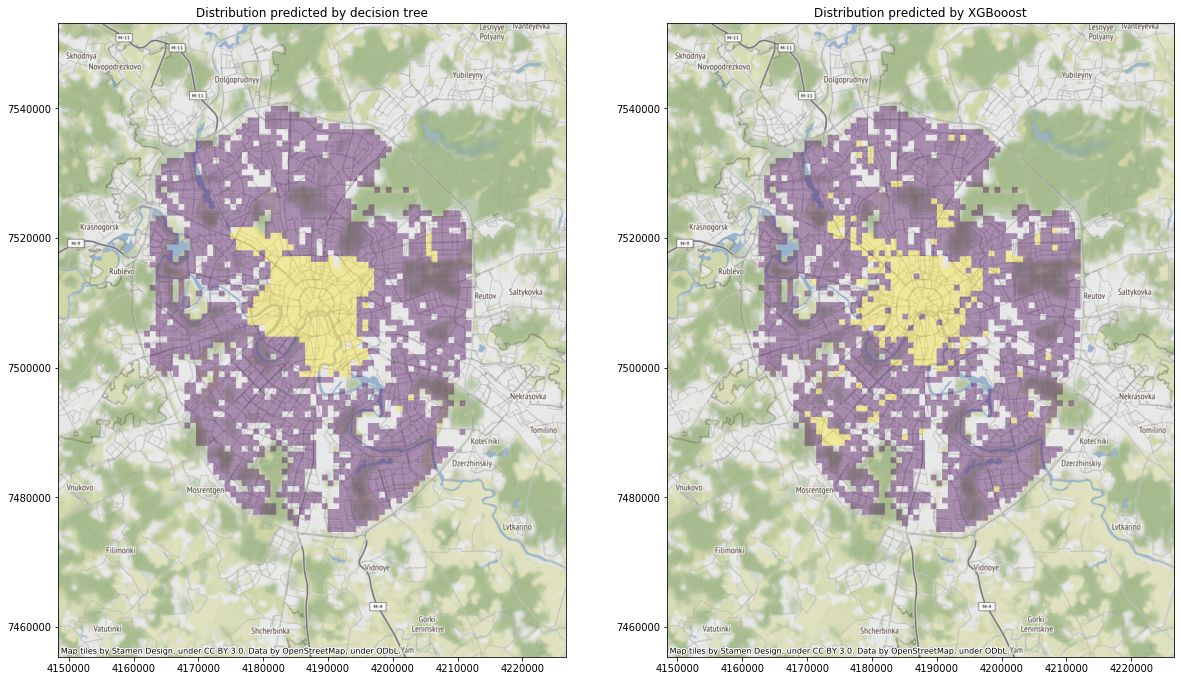

In [1091]:
fig, axs=plt.subplots(nrows=1, ncols=2, figsize=(20,20))
ax=axs[0]
ax1=axs[1]
df_moscow_geo=gpd.GeoDataFrame(df_moscow_features.merge(fish_moscow, on='Id'),geometry='geometry', crs={'init':'epsg:4326'})
df_moscow_geo.to_crs(epsg='3857').plot(column='is_crowded', figsize=(10,15),alpha=0.4, ax=ax )
df_moscow_geo.to_crs(epsg='3857').plot(column='is_predict_crowded', figsize=(10,15),alpha=0.4, ax=ax1 )
ax.set_title('Distribution predicted by decision tree')
ax1.set_title('Distribution predicted by XGBooost')
ctx.add_basemap(ax)
ctx.add_basemap(ax1)

## Information map and tourist centres allocation: Kmeans

In [777]:
from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler

ss=StandardScaler()

In [1300]:
def get_centroids(df, n_clust, buffer, col_buffer): # running kmeans to find clusters and centroids that are hypothetically the best points of facilities allocation 
    X_kmeans=df[['lat_x','long_x', 'predict_tourist']]
    X_kmeans=ss.fit_transform(X_kmeans)
    k_model=KMeans(n_clusters=n_clust)
    v=KMeans.fit_predict(k_model, X=X_kmeans)
#     print(v.shape)
    df_centroid=pd.DataFrame(ss.inverse_transform(k_model.cluster_centers_), columns=['lat_centr','long_centr', 'pt'])
    df_centroid['geometry']=df_centroid.apply(lambda row: Point(row['lat_centr'],row['long_centr']), axis=1)
    df_centroid=gpd.GeoDataFrame(df_centroid, crs=df_crowded.crs, geometry='geometry' ).to_crs(epsg='3857')
    df_centroid[col_buffer]=df_centroid[['geometry']].buffer(buffer)
    return df_centroid, v

def plot_uncovered_area(df_centroid, df_crowded, col_buffer, flag_optimized,clust_col, if_clust): # build map using found cetroids
    if flag_optimized:
        df_map_uncovered_up=gpd.overlay(df_crowded[['predict_tourist','geometry', clust_col]], df_centroid[[col_buffer]].set_geometry(col_buffer),
           how='difference')
    else:
        df_map_uncovered_up=gpd.overlay(df_crowded[['predict_tourist','geometry']], df_centroid[[col_buffer]].set_geometry(col_buffer),
           how='difference')
    fig,ax=plt.subplots( figsize=(10,16))
    
    df_crowded.plot( ax=ax, color='red',alpha=0.5, label=True)
    df_centroid.plot(ax=ax, color='red')
    df_centroid.set_geometry(col_buffer).plot(ax=ax,  color='none', linewidth=0.5, edgecolor='red')
    if if_clust:
        df_map_uncovered_up.plot(ax=ax, column=clust_col, alpha=0.7)
    else:
        df_map_uncovered_up.plot(ax=ax, color='grey', alpha=1)
    if flag_optimized:
        s='after optimisation'
    else:
        s='before optimisation'
    ax.set_title('Matching distribution of information maps with tourist density in Moscow '+ s)
    ctx.add_basemap(ax)
    return df_map_uncovered_up

### Allocation of information maps

In [1218]:
df_crowded=df_moscow_features[df_moscow_features['is_predict_crowded']==1]
df_crowded=gpd.GeoDataFrame(df_crowded.merge(fish_moscow, on='Id'),geometry='geometry', crs={'init':'epsg:4326'})

df_crowded3857=df_crowded.to_crs(epsg='3857')

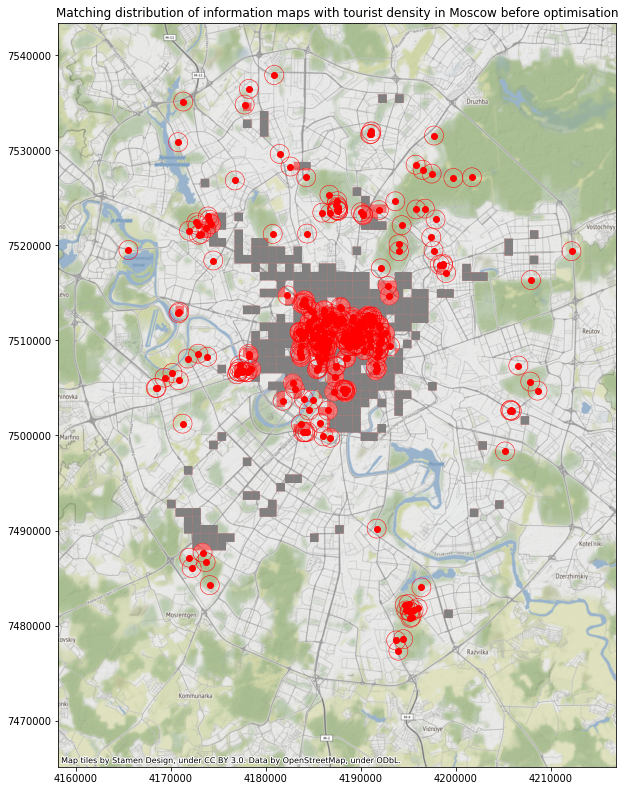

In [1363]:
df_osm3857.loc[df_osm3857['facility']=='map','map_buffer']=df_osm3857[df_osm3857['facility']=='map'].buffer(1000)
df_uncovered_map=plot_uncovered_area(df_osm3857[df_osm3857['facility']=='map'], df_crowded3857, 'map_buffer', False,'',False)

In [1302]:
df_uncovered_map.area.sum()/(10**6)

183.01838203113735

Current distribution cover only 38 % percent of popular tourist area

In [1337]:
1-df_uncovered_map.area.sum()/df_crowded3857.area.sum()

0.3805035066957273

In [ ]:
## Calculate number of maps we assume that the rest maps were installed for citizens needs, for example in parks or zones with low level of internet signal

In [1303]:
num_tour_maps=gpd.overlay( df_osm3857[df_osm3857['facility']=='map'].reset_index()[['map_buffer', 'index']].set_geometry('map_buffer'),df_crowded3857[['predict_tourist','geometry']],
           how='intersection')['index'].nunique()
num_tour_maps

230

After using kmeans, we improved current distribution of maps, thus covering 99% of tourist area. It is important to note that we changed location only those maps that have already been located within tourist area, whereas the rest remain at the same places. 

In [1221]:
df_centr_maps, df_crowded3857['clust'+str(num_tour_maps)]=get_centroids(df_crowded, num_tour_maps, 1000)

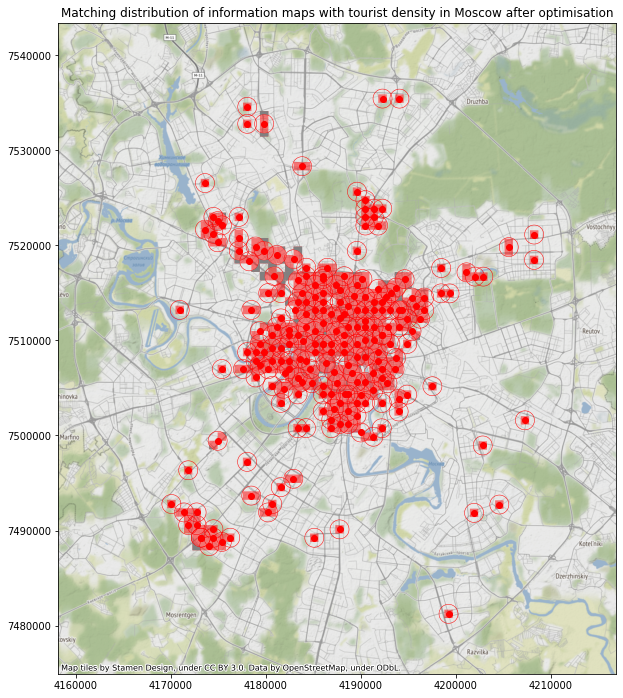

In [1237]:
df_uncov_maps_opt=plot_uncovered_area(df_centr_maps,df_crowded3857, True, 'clust230', False)

In [1296]:
df_uncov_maps_opt.area.sum()/(10**6)

6.569823223178455

In [1339]:
# uncovered by maps area after optimisation
1-df_uncov_maps_opt.area.sum()/df_crowded3857.area.sum()

0.9777618925311251

### Allocation of information centers

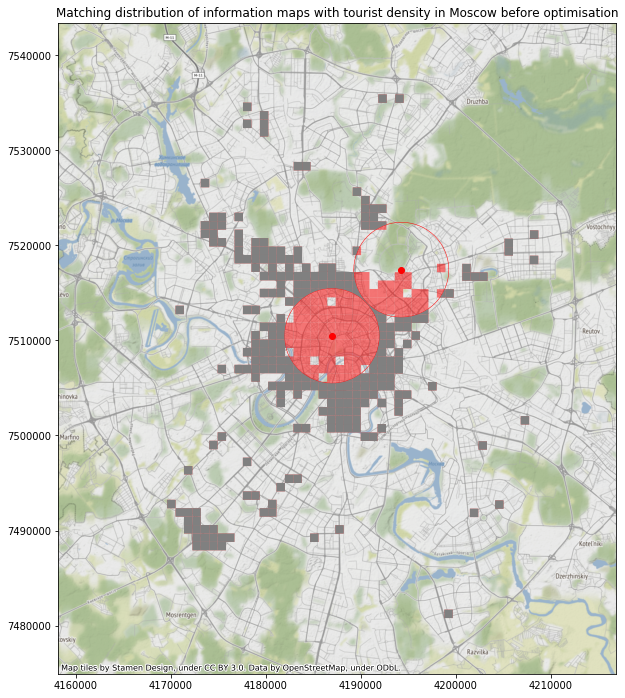

In [1304]:
df_osm3857.loc[df_osm3857['facility']=='office','office_buffer']=df_osm3857[df_osm3857['facility']=='office'].buffer(5000)
df_uncovered_office=plot_uncovered_area(df_osm3857[df_osm3857['facility']=='office'], df_crowded3857,'office_buffer', False,'', False )

In [1305]:
df_uncovered_office.area.sum()/(10**6)

195.96907323344107

In [1332]:
rate_uncov_off_unopt=1-(df_uncovered_office.area.sum()/df_crowded3857.area.sum())
print('covered area is', round(rate_uncov_off_unopt,2))

covered area is 0.34


In [1306]:
df_centr_offices, df_crowded3857['clust_2']=get_centroids(df_crowded, 2, 5000, 'office_buffer')

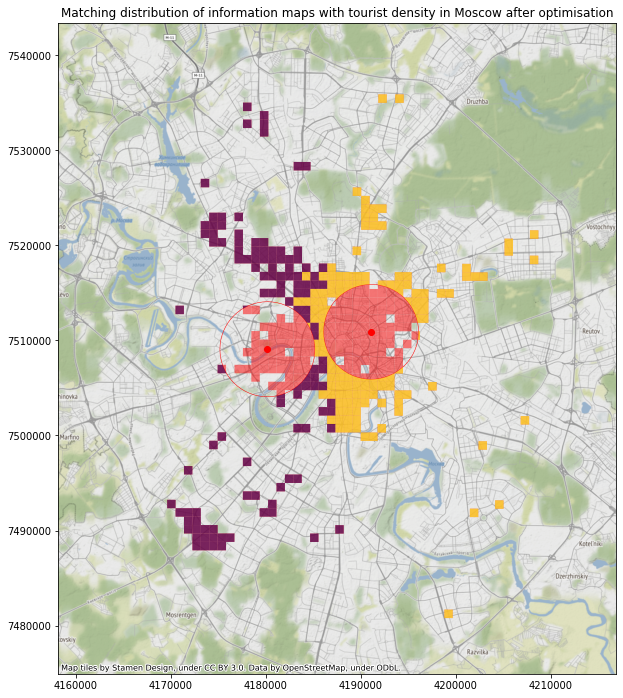

In [1307]:
df_uncov_off_opt=plot_uncovered_area(df_centr_offices,df_crowded3857,'office_buffer', True, 'clust_2', True)

In [1311]:
df_uncov_off_opt.area.sum()/(10**6)

182.34460606834648

In [1313]:
df_crowded3857.area.sum()/(10**6)

295.43086039914965

In [1316]:
rate_uncov_off=1-(df_uncov_off_opt.area.sum()/df_crowded3857.area.sum())

In [1328]:
print ('covered area is ',round(rate_uncov_off,2))

covered area is  0.38


## Summary of your findings and suggestions about improvement of information infrastructure 

In this project, machine learning algorithms ( XGBoost and Kmeans) were applied to analyse the current situation with distribution of information points in Moscow. How their location matches with numbers of tourists around was assessed based on one week observations of tourist density and data about infrastructure and attractions from open sources. Based on undertaken analysis we can recap on three outcomes. 

First of all, it revealed that determinants of relatively high tourist density are number of accomodations within two kilometers and number of cultural heritage within one. While we can witness the centricity of tourist flows, these features explain attraction of the place better than its coordinates. Rule 'number of accomodation within 2 km >=9 and number of cultural heritage within 1 km >=1' will allow to define new touristic spots with a good accuracy. If there is a need to predict the exact number of tourists,for example, to assess the capacity of new information center or other amenity,  apart from number of hotels and cultural sights, following features are important:
 - number of railway stations within 0.5
 - number of music venues in parks within 1km
 - number of theatres within 1 km
 - number of museums within 0.5 km
Also, it is important to note that during the cold monthes like April spatial patterns of tourist behavior do not vary significantly by the type of the day and period of the day. However to make more percise conclusions, data of warmer monthes should be analysed.
  
Next, we found out that there is only two tourist information offices in Moscow which covers only 33% of demand. With 5 km radius of buffer they cover crowded center of the city and area in north-west where park Sokolniki and square of Three Railway stations are located. Yet maps show us that the park is not popular among tourists during cold months, so the half of year the office is not in demand. At the same time, the area in north-west from the center ( Leningradskoy highway), in north (All-Russian Exhibition Center) both in high-demand in Moscow visitors, do not have any information points. 
Moreover, the analysis confirmed that more offices is needed because an attemt to improve it using clustering methosd increased the area of coverage only by 5%, whereas 60% of touristic area is not equipped by any informaition centers.

Last, we conclude the non-optimal allocation of information maps in the city. While according to Mayor of Moscow they were set to serve tourist needs, they cover only 38% of touristic area. Although there are 230 of them installed in touristic places, their distribution doesn't allow to satisfy tourist demands. Most of them concentrate in city centre around Kremlin, whereas an area around, including such places as Boulevard Ring, Moscow city and Moscow river waterfrontis are lack of navigation points. Meanwhile, applying optimisation method in this work proved that this number of maps in enough to meet needs of 97.8% visitors.  That is why, reallocation of information maps or installation of new ones if current maps do not describe surrounding area is recommended.